<a href="https://colab.research.google.com/github/kosmo-tony/Numerical-Optimization/blob/master/Error_accumulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The error accumulation in the conjugate gradient method for degenerate problem. Anton Ryabtsev. DCAM MIPT.**

In [ ]:
import numpy as np
import cupy as cp
from numpy.random import rand
import time
import random
from matplotlib import pyplot as plt
from scipy.stats import special_ortho_group
from scipy.optimize import minimize
from scipy.stats import bernoulli
from sklearn.linear_model import LinearRegression
                   
from matplotlib import rc

from copy import deepcopy

%matplotlib inline

# **Spectre generation**

In [ ]:
def generate_spectre(n1, n2, size, eps1, eps2): 
    spectre = np.concatenate((2 * eps1 * np.random.random_sample(size//2) - eps1 + n1, 2 * eps2 * np.random.random_sample(size//2) - eps2 + n2))
    return spectre

# **Plotting spectre**
Just to see how the eigenvalues are located on the x-axis.

In [ ]:
def plot_spectrum(coordinates):
    
    # Draw horizontal line
    plt.hlines(0, np.min(coordinates) - 0.1*np.max(coordinates), 1.1*np.max(coordinates))
    plt.xlim(np.min(coordinates) - 0.1*np.max(coordinates), 1.1*np.max(coordinates))
    plt.ylim(-0.5, 0.5)
    
    # Draw eig-values points
    y = np.zeros(np.shape(coordinates))
    plt.plot(coordinates, y, '|', label="Eigenvalues", mew=3, ms = 15)
    plt.xlabel('Eigenvalues', fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(20, 2.2)
    plt.legend(loc="best", fontsize=12)
    plt.yticks([])
    plt.savefig('Spectrum.pdf')
    plt.show()

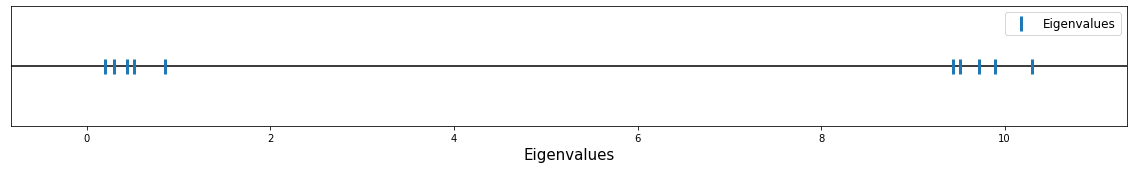

In [ ]:
plot_spectrum(generate_spectre(0.5, 10, 10, 0.4, 0.9))

# **Generating function and gradient**

* Function: $$f(x) = \dfrac{1}{2} x^TAx - b^Tx$$

* Gradient: $$\nabla f(x) = \dfrac{1}{2} (A + A^T)x - b$$

In [ ]:
def qf_params_cp(A, b, M_inv=None):
    '''A, b: cupy.array'''
    A = 0.5 * (A + A.T)
    return {'f': lambda x: 0.5 * cp.dot(cp.dot(x.T, A), x) - cp.dot(b.T, x), 'grad': lambda x: cp.dot(0.5*(A + A.T), x) - b, 'n': len(b)}

def qf_params(A, b, M_inv=None):
    '''A, b: numpy.array'''    
    if (np.array_equal(A, A.T) == False):
        A = 0.5 * (A + A.T)
    return {'f': lambda x: 0.5 * (x.T @ A @ x) - b.T @ x, 'grad': lambda x: 0.5 * (A + A.T) @ x - b, 'n': len(b)}

# **Noisy vector generation**

* ## **Basics**

  * $\|{\bf b}\|_2 = \sqrt{b_1^2 + b_2^2 + ... + b_n^2}$

  * $\|{\bf\tilde{b}} - {\bf b}\|_2 = \sqrt{(\tilde{b}_1 - b_1)^2 + (\tilde{b}_2 - b_2)^2 + ... + (\tilde{b}_n - b_n)^2} \le \delta_b$

  * $\|{\bf\tilde{b}} - {\bf b}\|_2 = \sqrt{\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2} \le \delta_b$

  * $\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2 \le \delta_b^2$


* ## **Antagonistic noise**

  * $\{\xi_i\}_{i=1}^n \in N(0, 1)$

  * ${\bf\Delta^k} = np.multiply(\sqrt{\dfrac{\boldsymbol{\xi}^2 \cdot \delta_b^2}{\sum_{i=1}^n\xi_i^2}},\; {\bf sign(Ax^k-b)})$ - normalization and elementwise product
  
  * ${\bf\tilde{b}^k} = {\bf b} + {\bf\Delta^k}$

  <!-- * $\Delta_1^2 = \Delta_2^2 = \dots = \Delta_N^2 = \Delta^2$
  * $N\Delta^2 = \delta_b^2$
  * ${\bf\Delta^k} = \dfrac{\delta_b}{\sqrt{N}} \cdot {\bf sign(Ax^k-b)}$
  * ${\bf\tilde{b^k}} = {\bf b} + {\bf\Delta^k}$ -->


* ## **Stochastic noise**

  * $\{\xi_i\}_{i=1}^n \in N(0, 1)$

  * ${\bf\Delta^k} = \sqrt{\dfrac{\boldsymbol{\xi}^2 \cdot \delta_b^2}{\sum_{i=1}^n\xi_i^2}}$ - normalization
  
  * ${\bf\tilde{b}^k} = {\bf b} \pm {\bf\Delta^k}$ - with probability $\dfrac{1}{2}$

  <!-- * $\Delta_1 = random.uniform(-\delta_b, \delta_b)$
  * $\Delta_2 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2}, \sqrt{\delta_b^2 -  \Delta_1^2})$
  * $\Delta_3 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2 - \Delta_2^2}, \sqrt  {\delta_b^2 - \Delta_1^2 - \Delta_2^2})$
  * ...
  * ${\bf\Delta^k} = (\Delta_1^k, \Delta_2^k, \dots, \Delta_n^k)^T$
  * ${\bf\tilde{b}^k} = {\bf b} + {\bf\Delta^k}$ -->

In [ ]:
def make_noisy_b(b, delta, concept, grad_xk=None):
    if concept == 1:
        deltas = np.zeros(len(b))
        deltas[0] = (np.random.uniform(-delta, delta))
        i = 1
        while i < len(b) and np.sum(np.array(deltas)**2) < delta**2:
            deltas[i] = (np.random.uniform(-np.sqrt(delta**2 - np.sum(np.array(deltas)**2)),\
                                           np.sqrt(delta**2 - np.sum(np.array(deltas)**2))))
            i += 1
        noisy_b = b + deltas        
    elif concept == 2:
        xis = np.random.randn(len(b))
        deltas = np.multiply(np.sqrt((xis**2 * np.float64(delta**2)) / np.sum(xis**2)), np.sign(cp.asnumpy(grad_xk)))
        noisy_b = b + cp.array(deltas)
    elif concept == 3:   
        xis = np.random.randn(len(b))
        deltas = np.sqrt((xis**2 * np.float64(delta**2)) / np.sum(xis**2))
        if bernoulli.rvs(size=1,p=0.5)[0] == 0:
            noisy_b = b - cp.array(deltas)
        else:
            noisy_b = b + cp.array(deltas)
    return noisy_b

# **Noisy matrix generation**

* $\|\tilde{A} - A\|_2 \le \delta_A$

* $\tilde{A} = A \pm M$~--~с вероятностью $\dfrac{1}{2}$, $\;\; M$~--~матрица шума  

* $\tilde{A} - A = \pm M$

* $\|M\|_2 \le \delta_A$

* $\{\xi_i\}_{i=1}^{n\times n} \in \mathcal{N}(0, 1)$

* $m_{1k} = \sqrt{\dfrac{\xi_k^2 \cdot \delta_A^2}{\sum_{i=1}^{n\times n}\xi_i^2}}$~--~нормировка первой строки матрицы шума
        
* $m_{2k} = \sqrt{\dfrac{\xi_{(2-1)n + k}^2 \cdot \delta_A^2}{\sum_{i=1}^{n\times n}\xi_i^2}}$~--~нормировка второй строки матрицы шума
        
*  $\dots$
        
* $m_{pk} = \sqrt{\dfrac{\xi_{(p-1)n + k}^2 \cdot \delta_A^2}{\sum_{i=1}^{n\times n}\xi_i^2}}$~--~нормировка $p$-ой строки матрицы шума
        
* $\dots$
        
* $m_{nk} = \sqrt{\dfrac{\xi_{(n-1)n + k}^2 \cdot \delta_A^2}{\sum_{i=1}^{n\times n}\xi_i^2}}$~--~нормировка последней строки матрицы шума      
        
* $M = \begin{bmatrix} m_{11} & m_{12} & \dots & m_{1n} \\ m_{21} & m_{22} & \dots & m_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ m_{n1} & m_{n_2} & \cdots & m_{nn}\end{bmatrix}$

In [ ]:
def make_noisy_A(A, delta):
    random_matrix = np.random.randn(A.shape[0], A.shape[0])
    matrix_of_noise = np.sqrt((random_matrix**2 * np.float64(delta**2)) / np.sum(random_matrix.flatten()**2))
    if bernoulli.rvs(size=1, p=0.5)[0] == 0:
        noisy_A = A - cp.array(matrix_of_noise)
    else:
        noisy_A = A + cp.array(matrix_of_noise)
   
    return noisy_A

# **My solver**

## **Algorithm (Fletcher-Reeves Method)**


### 1. Let $i = 0$ and $x_i = x_0 $, assume $ d_i = d_0 = - \nabla f (x_0) $.

### 2. We calculate $ \alpha $ minimizing $ f (x_i + \alpha_i d_i) $ using the formula

### $$
\alpha_i = - \frac{{d_i} ^ T (A x_i + b)}{{d_i} ^ T A d_i}
$$

### 3. Make the algorithm step:

### $$
x_{i + 1} = x_i + \alpha_i d_i
$$

### 4. Update the direction: $ d_{i + 1} = - \nabla f (x_{i + 1}) + \beta_i d_i $, where $ \beta_i $ is calculated by the formula:
### $$
\beta_i = \frac{\nabla f(x_ {i + 1}) ^ T A d_i}{{d_i} ^ T A d_i}
$$

### 5. Repeat steps 2-4 until the stopping criterion is fulfilled.

### **GPU CuPy solver**

#### Conjugate gradient method

In [ ]:
class CG_solver_cp():
    def __init__(self, starter_A, starter_b, accuracy=10**-3, factor=10, A=None, b=None, verbose=True):        
        self.accuracy = accuracy
        self.factor = factor
        self.verbose = verbose
        if A is not None:
            self.A = A
            self.starter_A = starter_A
        else:
            self.A = starter_A
        if b is not None:
            self.b = b
            self.starter_b = starter_b
        else:
            self.b = starter_b
        func = qf_params_cp(self.A, self.b)
        self.f = func['f']
        self.grad = func['grad']
        self.n = func['n']
        
        clear_func = qf_params_cp(starter_A, starter_b)
        self.clear_f = clear_func['f']

        self.d = -func['grad'](x0)
        self.alpha = 0
    
    def calculate_alpha(self, x):
        d = self.d
        grad = self.grad
        alpha = -float(cp.dot(d.T, grad(x))) / float(cp.dot(cp.dot(d.T, self.A), d))
        return alpha
    
    def calculate_beta(self, x, dx):
        d = self.d
        grad = self.grad
        beta = float(cp.dot(cp.dot(grad(x), self.A), d)) / float(cp.dot(cp.dot(d.T, self.A), d))
        return beta
    
    def solve(self, x0, save_trajectory=True, variable_tilde_A=False, variable_tilde_b=False,\
              delta_A=None, delta_b=None, concept=None, early_stop=True):
        if delta_A is None:
            delta_A = 0
        if delta_b is None:
            delta_b = 0
        func = qf_params_cp(self.A, self.b)
        g = self.grad(x0)
        i = 0
        errors = []
        trajectory = []
        func_trajectory = []
        # func_trajectory.append(float(self.clear_f(x0)))
        gradient_traj = []
        gradient_traj.append(np.linalg.norm(g, ord=2))
        trajectory.append(deepcopy(x0))
        x = deepcopy(x0)
        # criterion = self.accuracy
        # if (variable_tilde_A or variable_tilde_b):
        #     criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)

        while(np.linalg.norm(g, ord=2) > self.accuracy and i < (self.n * self.factor)-1):
        # while(np.linalg.norm(g, ord=2) > criterion and i < (self.n * self.factor)-1):
            i += 1
            if self.verbose and i % 100 == 0:
                print(f'i: {i}')
                # print(f'grad(x): {np.linalg.norm(g, ord=2)}')
            gradient_traj.append(np.linalg.norm(g, ord=2))
            if i % 50 == 0 and early_stop == True:
                if np.std(gradient_traj[-31:-1]) <= 5e-2:
                    break
            dx = self.calculate_alpha(x) * self.d            
            x += dx   
            g = self.grad(x)
            
            beta = self.calculate_beta(x, dx)
            self.d = -g + beta * self.d
            if variable_tilde_A:
                self.A = make_noisy_A(self.starter_A, delta_A)
            if variable_tilde_b:
                self.b = make_noisy_b(self.starter_b, delta_b, concept=concept, grad_xk=func['grad'](x))
            if (variable_tilde_A or variable_tilde_b):
                func = qf_params_cp(self.A, self.b)
                self.f = func['f']
                self.grad = func['grad']
                # criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)
            trajectory.append(deepcopy(x))
            func_trajectory.append(float(self.clear_f(x)))
#         print(f'grad(x): {np.linalg.norm(g, ord=2)}')
        if save_trajectory:
            return {'trajectory' : trajectory, 'func' : func_trajectory, "num_iter": i}
        else:
            return {'x' : self.x, "num_iter": i}

#### Heavy ball method

In [ ]:
class FGM_solver_cp():
    def __init__(self, starter_A, starter_b, accuracy=10**-3, factor=10, alpha=0.1, beta=0.9, A=None, b=None, verbose=True):        
        func = qf_params_cp(starter_A, starter_b)
        self.accuracy = accuracy
        self.factor = factor
        self.verbose = verbose
        if A is not None:
            self.A = A
            self.starter_A = starter_A
        else:
            self.A = starter_A
        if b is not None:
            self.b = b
            self.starter_b = starter_b
        else:
            self.b = starter_b
        func = qf_params_cp(self.A, self.b)
        self.f = func['f']
        self.grad = func['grad']
        self.n = func['n']

        clear_func = qf_params_cp(starter_A, starter_b)
        self.clear_f = clear_func['f']

        self.alpha = alpha
        self.beta = beta
    
    def solve(self, x0, save_trajectory=True, variable_tilde_A=False, variable_tilde_b=False,\
              delta_A=None, delta_b=None, concept=None, early_stop=True):
        if delta_A is None:
            delta_A = 0
        if delta_b is None:
            delta_b = 0
        func = qf_params_cp(self.A, self.b)
        g = self.grad(x0)
        i = 0
        trajectory = []
        func_trajectory = []
        gradient_traj = []
        gradient_traj.append(np.linalg.norm(g, ord=2))
        trajectory.append(deepcopy(x0))
        x = deepcopy(x0)
        # criterion = self.accuracy
        # if (variable_tilde_A or variable_tilde_b):
        #     criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)

        while(np.linalg.norm(g, ord=2) > self.accuracy and i < (self.n * self.factor)-1):
        # while(np.linalg.norm(g, ord=2) > criterion and i < (self.n * self.factor)-1):
            if i == 0:
                prev_x = deepcopy(x)
                x = x - self.alpha * g
            else:
                temp_x = deepcopy(x)
                x = x - self.alpha * g + self.beta * (x - prev_x)
                prev_x = deepcopy(temp_x)
            i += 1
            if self.verbose and i % 100 == 0:
                print(f'i: {i}')
                # print(f'grad(x): {np.linalg.norm(g, ord=2)}')
            gradient_traj.append(np.linalg.norm(g, ord=2))
            g = self.grad(x)
            
            if variable_tilde_A:
                self.A = make_noisy_A(self.starter_A, delta_A)
            if variable_tilde_b:
                self.b = make_noisy_b(self.starter_b, delta_b, concept=concept, grad_xk=func['grad'](x))
            if (variable_tilde_A or variable_tilde_b):
                func = qf_params_cp(self.A, self.b)
                self.f = func['f']
                self.grad = func['grad']
                # criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)
            func_trajectory.append(float(self.clear_f(x)))
            trajectory.append(deepcopy(x))
#         print(f'grad(x): {np.linalg.norm(g, ord=2)}')
        if save_trajectory:
            return {'trajectory' : trajectory, 'func' : func_trajectory, "num_iter": i}
        else:
            return {'x' : self.x, "num_iter": i}

#### Nesterov method

In [ ]:
class Nesterov_method_solver_cp():
    def __init__(self, starter_A, starter_b, accuracy=10**-3, factor=10, alpha=0.1, beta=0.9, A=None, b=None, verbose=True):        
        func = qf_params_cp(starter_A, starter_b)
        self.accuracy = accuracy
        self.factor = factor
        self.verbose = verbose
        if A is not None:
            self.A = A
            self.starter_A = starter_A
        else:
            self.A = starter_A
        if b is not None:
            self.b = b
            self.starter_b = starter_b
        else:
            self.b = starter_b
        func = qf_params_cp(self.A, self.b)
        self.f = func['f']
        self.grad = func['grad']
        self.n = func['n']

        clear_func = qf_params_cp(starter_A, starter_b)
        self.clear_f = clear_func['f']

        self.alpha = alpha
        self.beta = beta
    
    def solve(self, x0, save_trajectory=True, variable_tilde_A=False, variable_tilde_b=False,\
              delta_A=None, delta_b=None, concept=None, early_stop=True):
        if delta_A is None:
            delta_A = 0
        if delta_b is None:
            delta_b = 0
        func = qf_params_cp(self.A, self.b)
        g = self.grad(x0)
        i = 0
        trajectory = []
        func_trajectory = []
        gradient_traj = []
        gradient_traj.append(np.linalg.norm(g, ord=2))
        trajectory.append(deepcopy(x0))
        x = deepcopy(x0)
        # criterion = self.accuracy
        # if (variable_tilde_A or variable_tilde_b):
        #     criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)

        while(np.linalg.norm(g, ord=2) > self.accuracy and i < (self.n * self.factor)-1):
        # while(np.linalg.norm(g, ord=2) > criterion and i < (self.n * self.factor)-1):
            if i == 0:
                prev_x = deepcopy(x)
                x = x - self.alpha * g
            else:
                temp_x = deepcopy(x)
                x = x - self.alpha * g + self.beta * (x - prev_x)
                prev_x = deepcopy(temp_x)
            i += 1
            if self.verbose and i % 100 == 0:
                print(f'i: {i}')
                # print(f'grad(x): {np.linalg.norm(g, ord=2)}')
            gradient_traj.append(np.linalg.norm(g, ord=2))
            g = self.grad(x + self.beta * (x - prev_x))
            
            if variable_tilde_A:
                self.A = make_noisy_A(self.starter_A, delta_A)
            if variable_tilde_b:
                self.b = make_noisy_b(self.starter_b, delta_b, concept=concept, grad_xk=func['grad'](x))
            if (variable_tilde_A or variable_tilde_b):
                func = qf_params_cp(self.A, self.b)
                self.f = func['f']
                self.grad = func['grad']
                # criterion = 2.5 * (delta_A * np.linalg.norm(x) + delta_b)
            func_trajectory.append(float(self.clear_f(x)))
            trajectory.append(deepcopy(x))
#         print(f'grad(x): {np.linalg.norm(g, ord=2)}')
        if save_trajectory:
            return {'trajectory' : trajectory, 'func' : func_trajectory, "num_iter": i}
        else:
            return {'x' : self.x, "num_iter": i}

## **Task builder**

In [ ]:
def rand_perm_mat(N):
    I = np.eye(N)
    p = np.random.permutation(np.arange(N))
    return I[p]

In [ ]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

Use `special_ortho_group.rvs()` for tasks with $n \le 10^3$ and `rand_perm_mat()` for any.

In [ ]:
def make_task(N, min_eig_val_mean=None, max_eig_val_mean=None, eig_val_std1=None, eig_val_std2=None, R=None, verbose=False, uniform=None, seq=None, two_eigs=None):
    
    if uniform:
        spectre = np.random.uniform(0, 1, N)
        X = gram_schmidt_columns(np.random.uniform(-1, 1, (N, N)))
    elif seq:
        spectre = (np.arange(N) + 1)**2
        X = gram_schmidt_columns(np.random.uniform(-1, 1, (N, N)))
    elif two_eigs:
        spectre = np.concatenate((np.array([1/N] * int(N/2)), np.ones(int(N/2))))
        X = gram_schmidt_columns(np.random.uniform(-1, 1, (N, N)))
    else:
        spectre = generate_spectre(min_eig_val_mean, max_eig_val_mean, int(N), eig_val_std1, eig_val_std2)
        X = special_ortho_group.rvs(N)
        # X = rand_perm_mat(N)

    di = np.diag(spectre)    

    X = cp.array(X)
    di = cp.array(di)
    A = X.dot(di).dot(X.T)
    if np.any(R):
        if type(R) == np.float64 or type(R) == float or type(R) == int:
            # b = A.dot(cp.array([R / np.sqrt(N)] * N))
            # xis = np.random.randn(N)
            xis = rand(A.shape[0])
            xstar = np.sqrt((xis**2 * np.float64(R**2))/ np.sum(xis**2))
            b = A.dot(cp.array(xstar))
        else:
            b = [A.dot(cp.array([R[i] / np.sqrt(N)] * N)) for i in range(len(R))]
    else:
        b = cp.array(rand(A.shape[0]))
    x0 = cp.array(np.zeros(A.shape[0]))

    if verbose: print(f'Cond: {max(spectre)/min(spectre)}')
    
    return A, b, x0

In [ ]:
spectre = np.array([0.0001, 100])
X = gram_schmidt_columns(np.random.uniform(-1, 1, (2, 2)))
di = np.diag(spectre)    
A = X.dot(di).dot(X.T)

# Noise in vector b

\

## $$
f(x) = \dfrac{1}{2}x^TAx - \tilde{b}^Tx
$$

\

## $$
\|\tilde{b} - b\|_2 \le \delta_b
$$

\

## Trajectory on the **asymptote** - evidence of no accumulation of errors

### Antagonistic noise

In [ ]:
%%time
N = 2000
# R = 100
A, b, x0 = make_task(N, min_eig_val_mean=0.001, max_eig_val_mean=10000, eig_val_std1=0.0008, eig_val_std2=1, verbose=True)
R = np.linalg.norm(cp.asnumpy(cp.linalg.inv(A).dot(b)), ord=2)
print(f'R: {int(R)}')

Cond: 49683949.35861771
R: 29032
CPU times: user 37.3 s, sys: 1min 2s, total: 1min 40s
Wall time: 25.4 s


In [ ]:
d_b = 0.1
func = qf_params_cp(A, b)
noisy_b = make_noisy_b(b, d_b, concept=2, grad_xk=func['grad'](x0))

In [ ]:
%%time
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=5)
clear_task_res = solver1.solve(x0, early_stop=False)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=5, b=noisy_b)
noisy_task_res = solver1.solve(x0, variable_tilde_b=True, delta_b=d_b, concept=2, early_stop=False)

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
i: 2000
i: 2100
i: 2200
i: 2300
i: 2400
i: 2500
i: 2600
i: 2700
i: 2800
i: 2900
i: 3000
i: 3100
i: 3200
i: 3300
i: 3400
i: 3500
i: 3600
i: 3700
i: 3800
i: 3900
i: 4000
i: 4100
i: 4200
i: 4300
i: 4400
i: 4500
i: 4600
i: 4700
i: 4800
i: 4900
i: 5000
i: 5100
i: 5200
i: 5300
i: 5400
i: 5500
i: 5600
i: 5700
i: 5800
i: 5900
i: 6000
i: 6100
i: 6200
i: 6300
i: 6400
i: 6500
i: 6600
i: 6700
i: 6800
i: 6900
i: 7000
i: 7100
i: 7200
i: 7300
i: 7400
i: 7500
i: 7600
i: 7700
i: 7800
i: 7900
i: 8000
i: 8100
i: 8200
i: 8300
i: 8400
i: 8500
i: 8600
i: 8700
i: 8800
i: 8900
i: 9000
i: 9100
i: 9200
i: 9300
i: 9400
i: 9500
i: 9600
i: 9700
i: 9800
i: 9900
CPU times: user 1min 5s, sys: 32.5 s, total: 1min 37s
Wall time: 1min 37s


In [ ]:
func_trajectory = (np.array([func['f'](clear_task_res['trajectory'][i]) for i in range(len(clear_task_res['trajectory']))]) - \
                   np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                   np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))
noisy_func_trajectory = (np.array([func['f'](noisy_task_res['trajectory'][i]) for i in range(len(noisy_task_res['trajectory']))]) - \
                          np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                          np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))

In [ ]:
trajectory_for_gradient = clear_task_res['trajectory']
clear_task_res['trajectory'] = clear_task_res['trajectory'] + [clear_task_res['trajectory'][-1]] * (len(noisy_task_res['trajectory']) - len(clear_task_res['trajectory']))
func_trajectory = list(func_trajectory) + [func_trajectory[-1]] *  (len(noisy_func_trajectory) - len(func_trajectory))

func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
# scipy_res = minimize(func_np['f'], cp.asnumpy(x0), method='CG', jac=func_np['grad'], options={'disp': True})

R = np.linalg.norm(clear_task_res['trajectory'][-1] - x0)

# print(f"scipy f*: {scipy_res.fun}")
print(f"orig  f*: {func['f'](clear_task_res['trajectory'][-1])}\nnoisy f*: {func['f'](noisy_task_res['trajectory'][-1])}\nerror: {np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1]))}")
print(f"R: {R}")
print(f"x*-nx*: {np.linalg.norm(clear_task_res['trajectory'][-1] - noisy_task_res['trajectory'][-1])}")

orig  f*: -216277.94504003404
noisy f*: -216268.55599660575
error: 9.389043428294826
R: 29032.402285141157
x*-nx*: 280.89628159344494


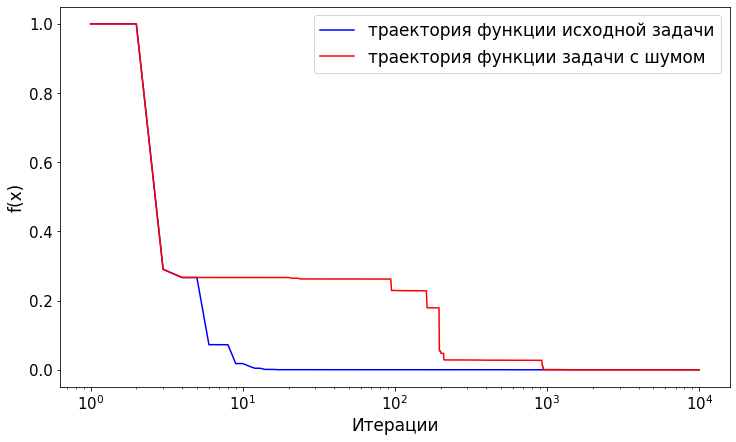

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), func_trajectory, color='b', label='траектория функции исходной задачи')
plt.semilogx(np.linspace(1, len(noisy_task_res['trajectory']), len(noisy_task_res['trajectory'])), noisy_func_trajectory, color='r', label='траектория функции задачи с шумом')

# plt.title(f'\n Концепция аддитивного враждебного шума \n n = {N} \t $\delta_b$ = {d_b}\t R = {int(R)}', fontsize=17)
plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
plt.show();
# f.savefig(f"Antagonistic_noise_delta_b{d_b}_dim{N}.pdf", bbox_inches='tight')

#### Function residual

In [ ]:
func_residual = [func['f'](noisy_task_res['trajectory'][i]) - func['f'](clear_task_res['trajectory'][-1]) for i in range(len(noisy_task_res['trajectory']))]

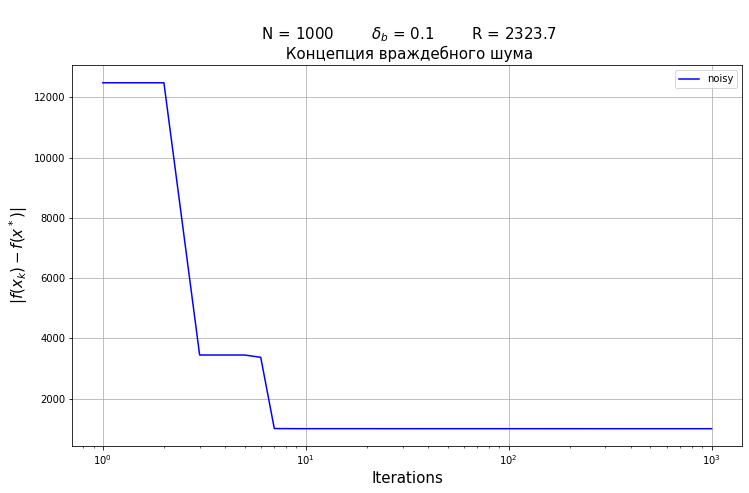

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), func_residual, color='b', label='noisy')

plt.title(f'\n N = {N} \t $\delta_b$ = {d_b} \t R = {np.round(R,1)}\n Концепция враждебного шума', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('$\|f(x_k) - f(x^*)\|$', fontsize=15)
# plt.yticks(rotation=90)
plt.grid()
plt.legend(loc=1)
plt.show();
# f.savefig(f"f_residual_noise_type2_delta_b{d_b}_dim{N}.pdf", bbox_inches='tight')

#### Argument residual

In [ ]:
arg_residual = np.array([np.linalg.norm(noisy_task_res['trajectory'][i] - clear_task_res['trajectory'][-1], ord=2) for i in range(len(noisy_task_res['trajectory']))])
# нормировка:
arg_residual = arg_residual / np.float64(arg_residual[0])

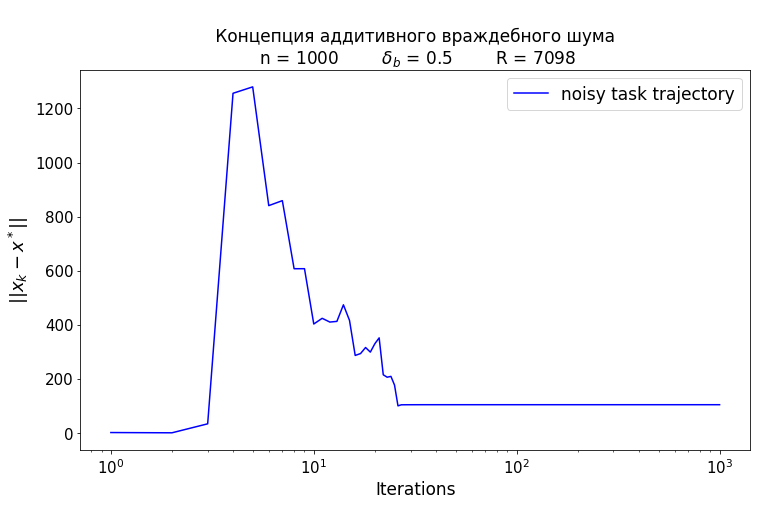

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), arg_residual, color='b', label='noisy task trajectory')

plt.title(f'\n Концепция аддитивного враждебного шума \n n = {N} \t $\delta_b$ = {d_b} \t R = {int(R)}', fontsize=17)
plt.xlabel('Iterations', fontsize=17)
plt.ylabel('$||x_k - x^*||$', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
plt.show();
# f.savefig(f"x_residual_antagonistic_noise_delta_b{d_b}_dim{N}.pdf", bbox_inches='tight')

### Stochastic noise

In [ ]:
%%time
N = 10000
A, b, x0 = make_task(N, 0.01, 100000, 0.008, 100, verbose=True)

Cond: 49775051.42053598
CPU times: user 776 ms, sys: 740 ms, total: 1.52 s
Wall time: 1.51 s


In [ ]:
d_b = 0.1
func = qf_params_cp(A, b)
noisy_b = make_noisy_b(b, d_b, concept=3)

In [ ]:
%%time
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1)
clear_task_res = solver1.solve(x0, early_stop=False)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, b=noisy_b)
noisy_task_res = solver1.solve(x0, variable_tilde_b=True, delta_b=d_b, concept=3, early_stop=False)

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
i: 2000
i: 2100
i: 2200
i: 2300
i: 2400
i: 2500
i: 2600
i: 2700
i: 2800
i: 2900
i: 3000
i: 3100
i: 3200
i: 3300
i: 3400
i: 3500
i: 3600
i: 3700
i: 3800
i: 3900
i: 4000
i: 4100
i: 4200
i: 4300
i: 4400
i: 4500
i: 4600
i: 4700
i: 4800
i: 4900
i: 5000
i: 5100
i: 5200
i: 5300
i: 5400
i: 5500
i: 5600
i: 5700
i: 5800
i: 5900
i: 6000
i: 6100
i: 6200
i: 6300
i: 6400
i: 6500
i: 6600
i: 6700
i: 6800
i: 6900
i: 7000
i: 7100
i: 7200
i: 7300
i: 7400
i: 7500
i: 7600
i: 7700
i: 7800
i: 7900
i: 8000
i: 8100
i: 8200
i: 8300
i: 8400
i: 8500
i: 8600
i: 8700
i: 8800
i: 8900
i: 9000
i: 9100
i: 9200
i: 9300
i: 9400
i: 9500
i: 9600
i: 9700
i: 9800
i: 9900
CPU times: user 27min 2s, sys: 19min 21s, total: 46min 23s
Wall time: 46min 22s


In [ ]:
func_trajectory = (np.array([func['f'](clear_task_res['trajectory'][i]) for i in range(len(clear_task_res['trajectory']))]) - \
                   np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                   np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))
noisy_func_trajectory = (np.array([func['f'](noisy_task_res['trajectory'][i]) for i in range(len(noisy_task_res['trajectory']))]) - \
                          np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                          np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))

In [ ]:
trajectory_for_gradient = clear_task_res['trajectory']
clear_task_res['trajectory'] = clear_task_res['trajectory'] + [clear_task_res['trajectory'][-1]] * (len(noisy_task_res['trajectory']) - len(clear_task_res['trajectory']))
func_trajectory = list(func_trajectory) + [func_trajectory[-1]] *  (len(noisy_func_trajectory) - len(func_trajectory))

# func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
# scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': True})

R = np.linalg.norm(clear_task_res['trajectory'][-1] - x0)

# print(f"scipy f*: {scipy_res.fun}")
print(f"orig  f*: {func['f'](clear_task_res['trajectory'][-1])}\nnoisy f*: {func['f'](noisy_task_res['trajectory'][-1])}\nerror: {np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1]))}")
print(f"R: {R}")
print(f"x*-nx*: {np.linalg.norm(clear_task_res['trajectory'][-1] - noisy_task_res['trajectory'][-1])}")

orig  f*: -116171.83387397113
noisy f*: -116171.72950929028
error: 0.10436468085390516
R: 6891.4001904187235
x*-nx*: 5.360527062574191


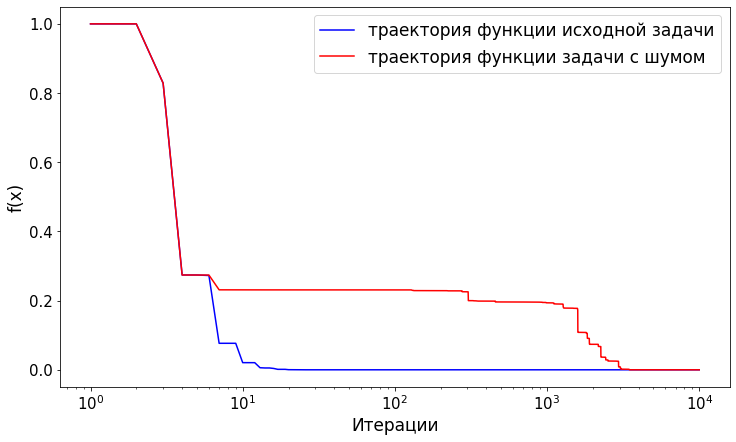

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), func_trajectory, color='b', label='траектория функции исходной задачи')
plt.semilogx(np.linspace(1, len(noisy_task_res['trajectory']), len(noisy_task_res['trajectory'])), noisy_func_trajectory, color='r', label='траектория функции задачи с шумом')

# plt.title(f'\n Концепция аддитивного стохастического шума \n n = {N} \t $\delta_b$ = {d_b}\t R = {int(R)}', fontsize=17)
plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)

plt.show();
# f.savefig(f"Stochastic_noise_delta_b{d_b}_dim{N}.pdf", bbox_inches='tight')

#### Argument residual

In [ ]:
arg_residual = np.array([np.linalg.norm(noisy_task_res['trajectory'][i] - clear_task_res['trajectory'][-1], ord=2) for i in range(len(noisy_task_res['trajectory']))])
# нормировка:
arg_residual = arg_residual / np.float64(arg_residual[0])

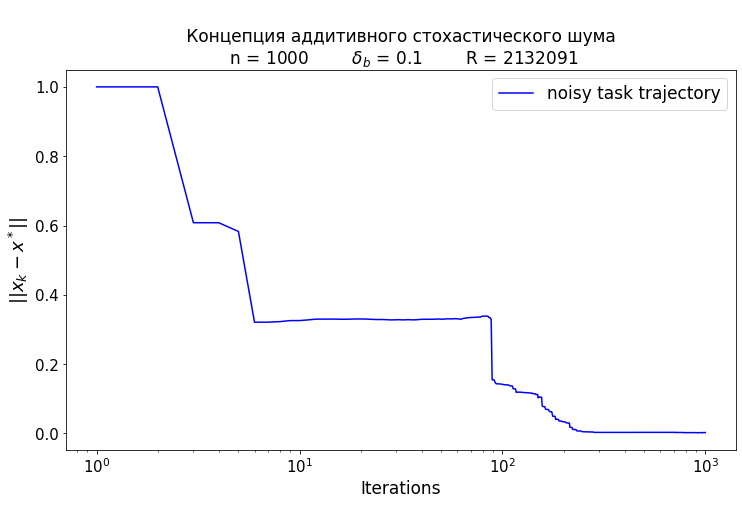

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), arg_residual, color='b', label='noisy task trajectory')

plt.title(f'\n Концепция аддитивного стохастического шума \n n = {N} \t $\delta_b$ = {d_b} \t R = {int(R)}', fontsize=17)
plt.xlabel('Iterations', fontsize=17)
plt.ylabel('$||x_k - x^*||$', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)

plt.show();
# f.savefig(f"x_residual_stochastic_noise_delta_b{d_b}_dim{N}.pdf", bbox_inches='tight')

## $\delta$ dependency

### Antagonistic noise.

In [ ]:
N = 100
# R = 100 # можно менять - интересный участок: (0, 1000]
# A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=10000000, eig_val_std1=0.008, eig_val_std2=100, verbose=True)
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, verbose=True)
R = np.linalg.norm(cp.asnumpy(cp.linalg.inv(A).dot(b)), ord=2)

Cond: 305014.153172005


In [ ]:
# здесь d_b - это наша \delta
d_b_min = 0 # лучше не менять, чтобы на графике была точка (0, 0)
d_b_max = 0.11 # можно менять, но лучше не ставить больше 1
d_b = np.arange(d_b_min, d_b_max, (d_b_max - d_b_min) / 21)
len(d_b)

21

In [ ]:
%%time
f_errors = []
f_errors_rel = []
x_errors = []
f_errors_good = []
f_errors_rel_good = []
x_errors_good = []
f_errors_bad = []
f_errors_rel_bad = []
x_errors_bad = []

func = qf_params_cp(A, b)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, verbose=False)
clear_task_res = solver1.solve(x0, early_stop=False)

for i in range(len(d_b)):
    # if int(i % (len(d_b)/10)) == 0:
        # print(f'{int(i/len(d_b) * 100)}%')
    print(f'{int(i/len(d_b) * 100)}%')

    x_errors_cur = []
    f_errors_cur = []
    f_errors_rel_cur = []    

    for j in range(1):        
        noisy_b = make_noisy_b(b, d_b[i], concept=2, grad_xk=func['grad'](x0))            
        solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=10, verbose=False, b=noisy_b)
        noisy_task_res = solver1.solve(x0, variable_tilde_b=True, delta_b=d_b[i], concept=2, early_stop=False)

        f_errors_rel_cur.append((np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))/\
                        np.abs(func['f'](clear_task_res['trajectory'][-1])))
        f_errors_cur.append(np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))
        x_errors_cur.append(np.linalg.norm(noisy_task_res['trajectory'][-1] - clear_task_res['trajectory'][-1]))
    f_errors.append(np.mean(f_errors_cur))
    x_errors.append(np.mean(x_errors_cur))
    f_errors_rel.append(np.mean(f_errors_rel_cur))
    f_errors_good.append(np.min(f_errors_cur))
    x_errors_good.append(np.min(x_errors_cur))
    f_errors_rel_good.append(np.min(f_errors_rel_cur))
    f_errors_bad.append(np.max(f_errors_cur))
    x_errors_bad.append(np.max(x_errors_cur))
    f_errors_rel_bad.append(np.max(f_errors_rel_cur))
print('100%')

0%
4%
9%
14%
19%
23%
28%
33%
38%
42%
47%
52%
57%
61%
66%
71%
76%
80%
85%
90%
95%
100%
CPU times: user 42 s, sys: 518 ms, total: 42.5 s
Wall time: 42.5 s


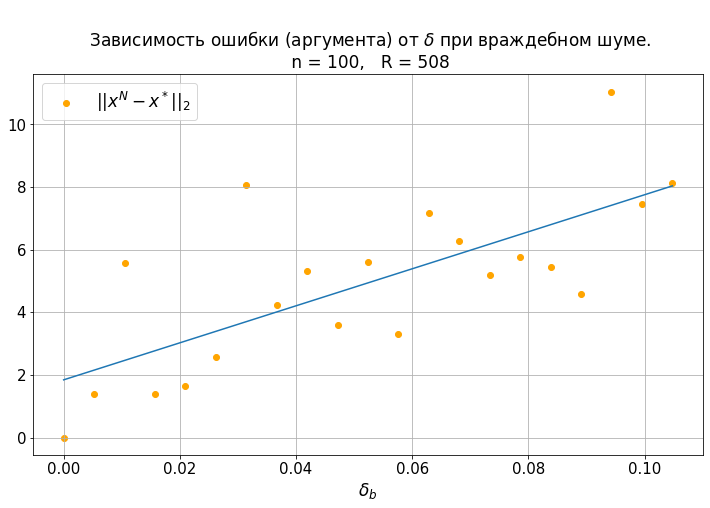

In [ ]:
reg = LinearRegression().fit(d_b.reshape(-1, 1), x_errors)
f = plt.figure(figsize=(12,7))
plt.scatter(d_b, np.array(x_errors), label='$||x^N - x^*||_2$', color='orange')
plt.plot(d_b, reg.predict(d_b.reshape(-1, 1)))
plt.title(f'\n Зависимость ошибки (аргумента) от $\delta$ при враждебном шуме.\n n = {N},   R = {int(R)}', fontsize=17) # \n Коэффициент наклона: {round(reg.coef_[0], 2)}
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize=17)

plt.show();
# f.savefig(f"x_error_antagonistic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

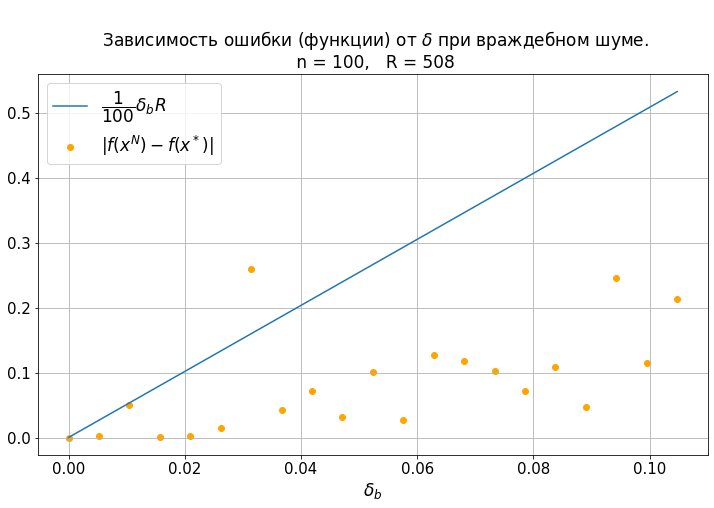

In [ ]:
f = plt.figure(figsize=(12,7))
plt.plot(d_b, 0.01 * d_b * R, label='$\dfrac{1}{100}\delta_b R$')
plt.scatter(d_b, np.array(f_errors), label='$|f(x^N) - f(x^*)|$', color='orange')
plt.title(f'\n Зависимость ошибки (функции) от $\delta$ при враждебном шуме.\n n = {N},   R = {int(R)}', fontsize=17)# Коэффициент наклона: {round(reg.coef_[0], 2)}', fontsize=15)
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize=17)
plt.show();
# f.savefig(f"f_error_antagonistic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

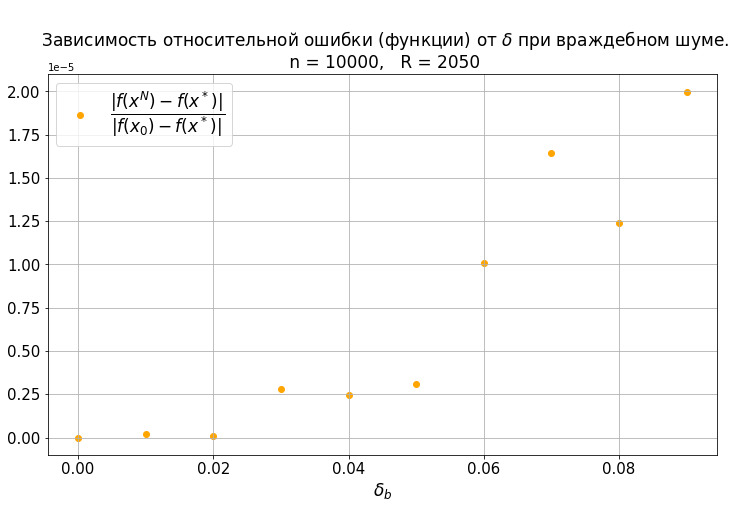

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(d_b, np.array(f_errors_rel_good), label='$\dfrac{|f(x^N) - f(x^*)|}{|f(x_0) - f(x^*)|}$', color='orange')
plt.title(f'\n Зависимость относительной ошибки (функции) от $\delta$ при враждебном шуме.\n n = {N},   R = {int(R)}', fontsize=17)# Коэффициент наклона: {round(reg.coef_[0], 2)}', fontsize=15)
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize=17)
plt.show();
# f.savefig(f"f_error_relative_antagonistic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

### Stochastic noise.

In [ ]:
N = 5000
# R = 1
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=100000, eig_val_std1=0.008, eig_val_std2=100, verbose=True)
R = np.linalg.norm(cp.asnumpy(cp.linalg.inv(A).dot(b)), ord=2)

Cond: 49991116.02598152


In [ ]:
# здесь d_b - это наша \delta
d_b_min = 0 # лучше не менять, чтобы на графике была точка (0, 0)
d_b_max = 0.1 # можно менять, но лучше не ставить больше 1
d_b = np.arange(d_b_min, d_b_max, (d_b_max - d_b_min) / 10)
len(d_b)

10

In [ ]:
%%time
f_errors_means = []
f_errors_rel_means = []
x_errors_means = []
f_errors_good = []
f_errors_rel_good = []
x_errors_good = []

func = qf_params_cp(A, b)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, verbose=False)
clear_task_res = solver1.solve(x0, early_stop=False)
for i in range(len(d_b)):
    # if i % 10 == 0:
        # print(f'i: {i}')
    print(f'{int(i/len(d_b) * 100)}%')
    f_errors = []
    f_errors_rel = []
    x_errors = []
    for j in range(1):
        
        noisy_b = make_noisy_b(b, d_b[i], concept=3)
        
        solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=50, verbose=False, b=noisy_b)
        noisy_task_res = solver1.solve(x0, variable_tilde_b=True, delta_b=d_b[i], concept=3, early_stop=False)

        f_errors_rel.append((np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))/\
                    np.abs(func['f'](clear_task_res['trajectory'][-1])))
        f_errors.append(np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))
        x_errors.append(np.linalg.norm(noisy_task_res['trajectory'][-1] - clear_task_res['trajectory'][-1]))
    f_errors_rel_means.append(np.mean(f_errors_rel))
    f_errors_means.append(np.mean(f_errors))
    x_errors_means.append(np.mean(x_errors))
    f_errors_rel_good.append(np.min(f_errors_rel))
    f_errors_good.append(np.min(f_errors))
    x_errors_good.append(np.min(x_errors))
print('100%')

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
CPU times: user 14min 55s, sys: 6.55 s, total: 15min 1s
Wall time: 15min 1s


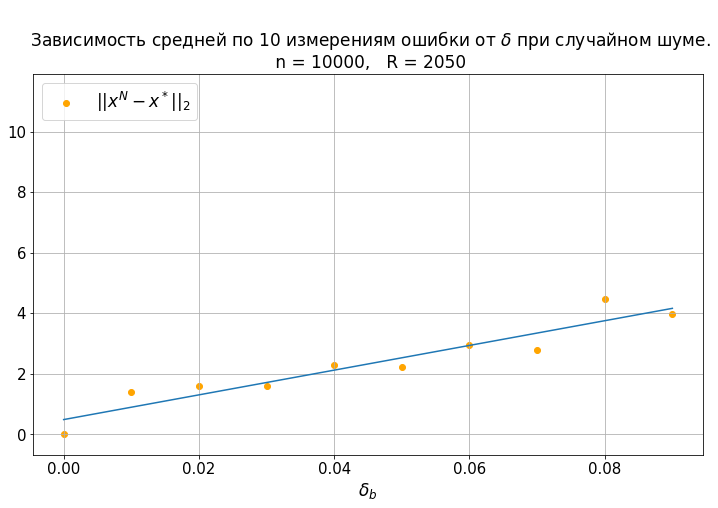

In [ ]:
reg = LinearRegression().fit(d_b.reshape(-1, 1), x_errors_means)
f = plt.figure(figsize=(12,7))
plt.scatter(d_b, x_errors_means, label='$||x^N - x^*||_2$', color='orange')
plt.plot(d_b, reg.predict(d_b.reshape(-1, 1)))
plt.title(f'\n Зависимость средней по 10 измерениям ошибки от $\delta$ при случайном шуме.\n n = {N},   R = {int(R)}', fontsize=17) # Коэффициент наклона: {round(reg.coef_[0], 2)}
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.ylim(3*plt.ylim()[0], 11 - 4*plt.ylim()[0])
plt.legend(loc='upper left', fontsize=17)
plt.show();
# f.savefig(f"x_error_stochastic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

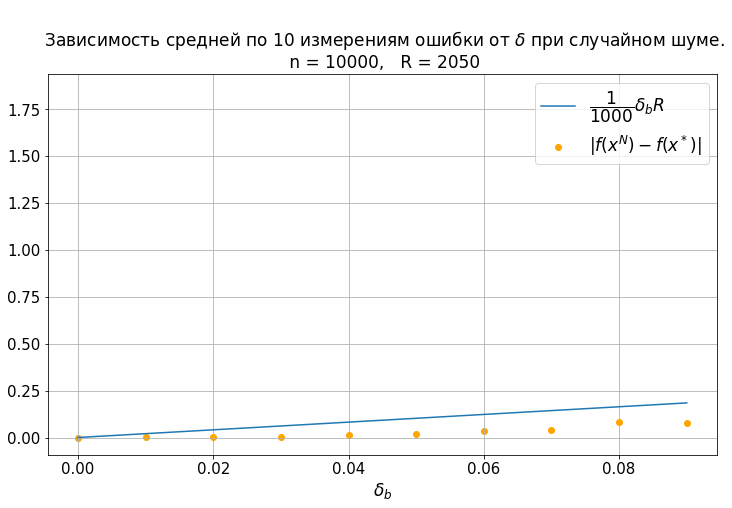

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(d_b, f_errors_means, label='$|f(x^N) - f(x^*)|$', color='orange')
plt.plot(d_b, 0.001 * d_b * R, label='$\dfrac{1}{1000}\delta_bR$')
plt.title(f'\n Зависимость средней по 10 измерениям ошибки от $\delta$ при случайном шуме.\n n = {N},   R = {int(R)}', fontsize=17)
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(10*plt.ylim()[0], 10*plt.ylim()[1])
plt.grid()
plt.legend(fontsize=17)
plt.show();
# f.savefig(f"f_error_stochastic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

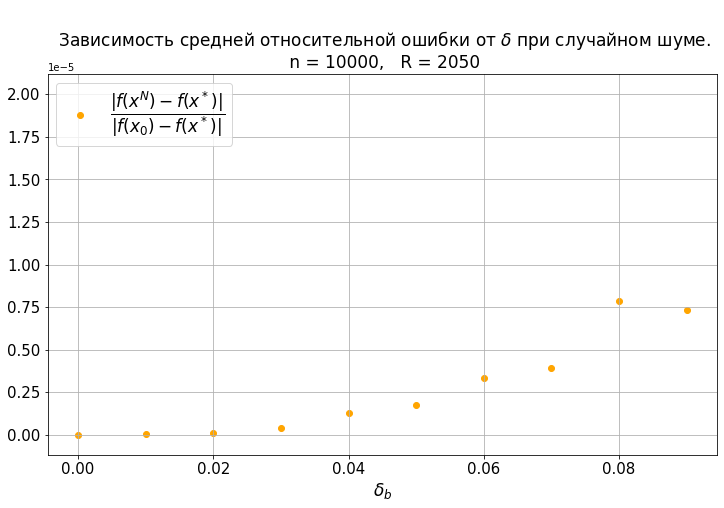

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(d_b, f_errors_rel_means, label='$\dfrac{|f(x^N) - f(x^*)|}{|f(x_0) - f(x^*)|}$', color='orange')
plt.title(f'\n Зависимость средней относительной ошибки от $\delta$ при случайном шуме.\n n = {N},   R = {int(R)}', fontsize=17)
plt.xlabel('$\delta_b$', fontsize=17)
plt.ylabel(None, fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
# plt.legend(fontsize=17)
plt.legend(loc='upper left', fontsize=17)
plt.ylim(3*plt.ylim()[0], -3*plt.ylim()[0] + 2e-5)
plt.show();
# f.savefig(f"f_rel_error_stochastic_noise_dim{N}_R{int(R)}_delta{np.round(d_b[0], 2)}-{np.round(d_b[-1], 2)}.pdf", bbox_inches='tight')

# Noise in matrix A.

\

## $$
f(x) = \dfrac{1}{2}x^T\tilde{A}x - b^Tx
$$

\

## $$
\|\tilde{A} - A\|_2 \le \delta_A
$$

\

## Asymptote

In [ ]:
%%time
N = 1000
# R = 10
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, verbose=True)

Cond: 487044.2974930352
CPU times: user 11.7 ms, sys: 4.29 ms, total: 16 ms
Wall time: 15.5 ms


In [ ]:
d_A = 0.005
func = qf_params_cp(A, b)
noisy_A = make_noisy_A(A, d_A)

In [ ]:
%%time
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1)
clear_task_res = solver1.solve(x0, early_stop=False)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, A=noisy_A)
noisy_task_res = solver1.solve(x0, variable_tilde_A=True, delta_A=d_A, early_stop=False)

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
CPU times: user 56.8 s, sys: 6.49 s, total: 1min 3s
Wall time: 1min 3s


In [ ]:
func_trajectory = (np.array([func['f'](clear_task_res['trajectory'][i]) for i in range(len(clear_task_res['trajectory']))]) - \
                   np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                   np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))
noisy_func_trajectory = (np.array([func['f'](noisy_task_res['trajectory'][i]) for i in range(len(noisy_task_res['trajectory']))]) - \
                          np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                          np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))

In [ ]:
trajectory_for_gradient = clear_task_res['trajectory']
clear_task_res['trajectory'] = clear_task_res['trajectory'] + [clear_task_res['trajectory'][-1]] * (len(noisy_task_res['trajectory']) - len(clear_task_res['trajectory']))
func_trajectory = list(func_trajectory) + [func_trajectory[-1]] *  (len(noisy_func_trajectory) - len(func_trajectory))

func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
# scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': True})

R = np.linalg.norm(clear_task_res['trajectory'][-1] - x0)

# print(f"scipy f*: {scipy_res.fun}")
print(f"orig  f*: {func['f'](clear_task_res['trajectory'][-1])}\nnoisy f*: {func['f'](noisy_task_res['trajectory'][-1])}\nerror: {np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1]))}")
print(f"R: {R}")
print(f"x*-nx*: {np.linalg.norm(clear_task_res['trajectory'][-1] - noisy_task_res['trajectory'][-1])}")

orig  f*: -11144.889772791863
noisy f*: -10978.888253040237
error: 166.0015197516259
R: 2066.4392369423763
x*-nx*: 289.2035516825715


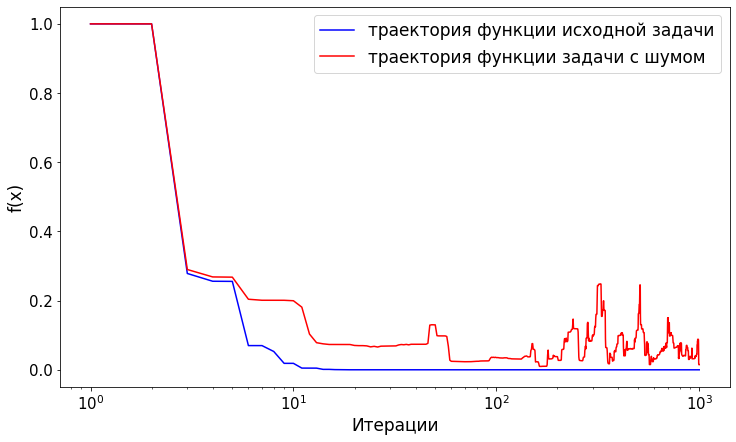

In [ ]:
f = plt.figure(figsize=(12,7))
# plt.plot(basic_x_stop, basic_y_stop, 'r|', label='basic stop point', ms = 15)
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), func_trajectory, color='b', label='траектория функции исходной задачи')
plt.semilogx(np.linspace(1, len(noisy_task_res['trajectory']), len(noisy_task_res['trajectory'])), noisy_func_trajectory, color='r', label='траектория функции задачи с шумом')
# plt.ylim(func['f'](clear_task_res['trajectory'][-1]) - 1, func['f'](noisy_task_res['trajectory'][-1]) + 5)
# plt.xlim(-0.1, 10)

# plt.title(f'\n Матрица с шумом \n n = {N} \t $\delta_A$ = {d_A}\t R = {int(R)}', fontsize=17)
plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)

plt.show();
# f.savefig(f"Noisy_matrix_delta_A{d_A}_dim{N}.pdf", bbox_inches='tight')

## $\delta$ dependency

In [ ]:
N = 100
R = 50
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, R=R, verbose=True)
# R = int(np.linalg.norm(np.linalg.inv(cp.asnumpy(A)) @ cp.asnumpy(b)))

Cond: 480420.14529931825


In [ ]:
d_A_min = 0
d_A_max = 0.0104
d_A = np.arange(d_A_min, d_A_max, (d_A_max - d_A_min) / 26)
len(d_A)

26

In [ ]:
%%time
f_errors = []
f_errors_rel = []
x_errors = []
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, verbose=False)
clear_task_res = solver1.solve(x0, early_stop=False)
for i in range(len(d_A)):
    # if int(i % (len(d_A)/10)) == 0:
    #     print(f'{int(i/len(d_A) * 100)}%')
    print(f'{int(i/len(d_A) * 100)}%')
    
    func = qf_params_cp(A, b)
    noisy_A = make_noisy_A(A, d_A[i])

    solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=200, verbose=False, A=noisy_A)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, delta_A=d_A[i], early_stop=False)

    f_errors_rel.append((np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))/\
                    np.abs(func['f'](clear_task_res['trajectory'][-1])))
    f_errors.append(np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))
    x_errors.append(np.linalg.norm(noisy_task_res['trajectory'][-1] - clear_task_res['trajectory'][-1]))
print('100%')

0%
3%
7%
11%
15%
19%
23%
26%
30%
34%
38%
42%
46%
50%
53%
57%
61%
65%
69%
73%
76%
80%
84%
88%
92%
96%
100%
CPU times: user 12.3 s, sys: 111 ms, total: 12.4 s
Wall time: 12.4 s


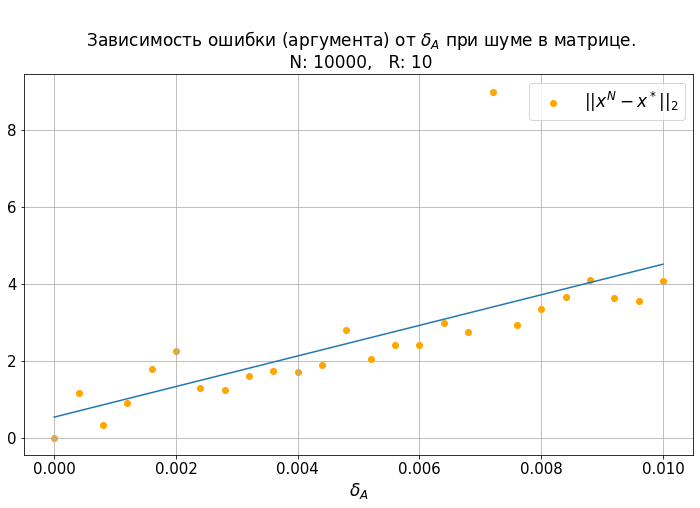

In [ ]:
reg = LinearRegression().fit(d_A.reshape(-1, 1), x_errors)
f = plt.figure(figsize=(12,7))
plt.scatter(d_A, np.array(x_errors), label='$||x^N - x^*||_2$', color='orange')
plt.plot(d_A, reg.predict(d_A.reshape(-1, 1)))
plt.title(f'\n Зависимость ошибки (аргумента) от $\delta_A$ при шуме в матрице.\n N: {N},   R: {R}', fontsize=17) # \n Коэффициент наклона: {round(reg.coef_[0], 2)}
plt.xlabel('$\delta_A$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_x_error_dim{N}_R{R}_delta{np.round(d_A[0], 2)}-{np.round(d_A[-1], 2)}.pdf", bbox_inches='tight')

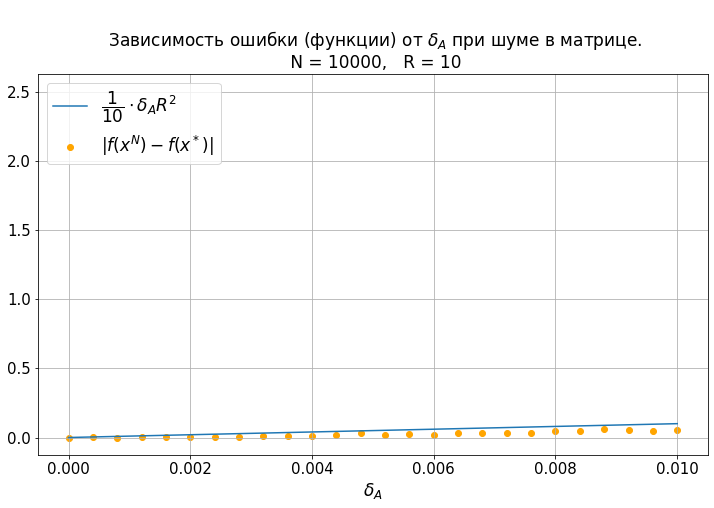

In [ ]:
f = plt.figure(figsize=(12,7))
plt.plot(d_A, 0.1 * d_A * R**2, label='$\dfrac{1}{10}\cdot\delta_A R^2$')
plt.scatter(d_A, np.array(f_errors), label='$|f(x^N) - f(x^*)|$', color='orange')
plt.title(f'\n Зависимость ошибки (функции) от $\delta_A$ при шуме в матрице.\n N = {N},   R = {R}', fontsize=17)
plt.xlabel('$\delta_A$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.ylim(-0.12499999999999999, 2.6249999999999996)
plt.legend(loc='upper left', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_f_error_dim{N}_R{R}_delta{np.round(d_A[0], 2)}-{np.round(d_A[-1], 2)}.pdf", bbox_inches='tight')

## R dependency

In [ ]:
N = 100
d_A = 0.01

R_min = 0
R_max = 21
R = np.arange(R_min, R_max, (R_max - R_min) / 21)
len(R)

21

In [ ]:
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, R=R, verbose=True)

Cond: 365017.9858783568


In [ ]:
f_errors = []
x_errors = []
for i in range(len(R)):
    # if i % 10 == 0:
        # print(f'{int(i/len(R) * 100)}%')
    print(f'{int(i/len(R) * 100)}%')
    
    func = qf_params_cp(A, b[i])
    noisy_A = make_noisy_A(A, d_A)

    solver1 = CG_solver_cp(starter_A=A, starter_b=b[i], accuracy=1e-2, factor=1, verbose=False)
    clear_task_res = solver1.solve(x0, early_stop=False)
    solver1 = CG_solver_cp(starter_A=A, starter_b=b[i], accuracy=1e-2, factor=100, verbose=False, A=noisy_A)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, delta_A=d_A, early_stop=False)

    f_errors.append(np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))
    x_errors.append(np.linalg.norm(noisy_task_res['trajectory'][-1] - clear_task_res['trajectory'][-1]))
print('100%')

0%
4%
9%
14%
19%
23%
28%
33%
38%
42%
47%
52%
57%
61%
66%
71%
76%
80%
85%
90%
95%
100%


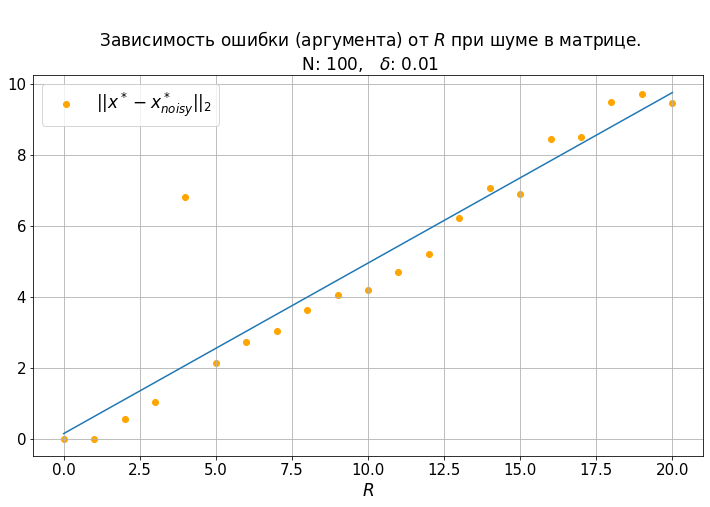

In [ ]:
reg = LinearRegression().fit(R.reshape(-1, 1), x_errors1)
f = plt.figure(figsize=(12,7))
plt.scatter(R, np.array(x_errors), label='$||x^* - x^*_{noisy}||_2$', color='orange')
plt.plot(R, reg.predict(R.reshape(-1, 1)))
plt.title(f'\n Зависимость ошибки (аргумента) от $R$ при шуме в матрице.\n N: {N},   $\delta$: {d_A}', fontsize=17) # \n Коэффициент наклона: {round(reg.coef_[0], 2)}
plt.xlabel('$R$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.ylim(-2.8550157999928905, 37.5109651006874)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_x_error_dim{N}_d_A{d_A}R{round(R[0])}-{round(R[-1])}.pdf", bbox_inches='tight')

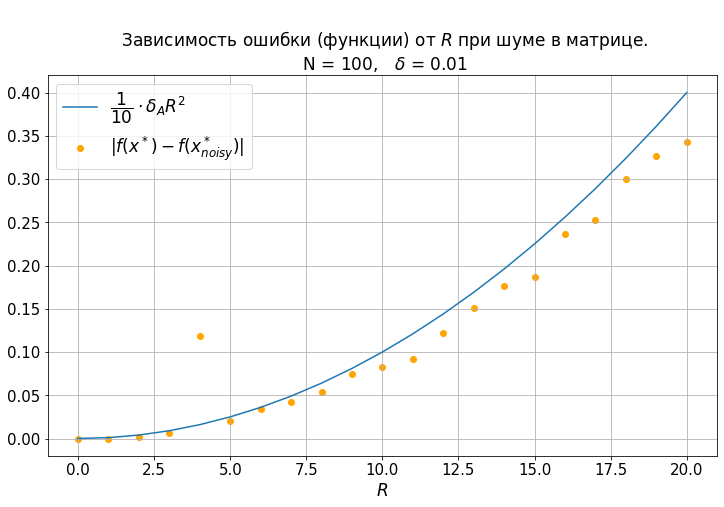

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(R, np.array(f_errors), label='$|f(x^*) - f(x^*_{noisy})|$', color='orange')
plt.plot(R, 0.1 * d_A * R**2, label='$\dfrac{1}{10}\cdot \delta_A R^2$')
plt.title(f'\n Зависимость ошибки (функции) от $R$ при шуме в матрице.\n N = {N},   $\delta$ = {d_A}', fontsize=17)# Коэффициент наклона: {round(reg.coef_[0], 2)}', fontsize=15)
plt.xlabel('$R$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.ylim(-0.20000000000000007, 4.200000000000001)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_f_error_dim{N}_d_A{d_A}R{round(R[0])}-{round(R[-1])}.pdf", bbox_inches='tight')

# Task with noise in matrix **A** and in vector **b**

\

## $$
f(x) = \dfrac{1}{2}x^T\tilde{A}x - \tilde{b}^Tx
$$

\

## $$
\|\tilde{A} - A\|_2 \le \delta_A
$$

\

## $$
\|\tilde{b} - b\|_2 \le \delta_b
$$

\

## Asymptote

In [ ]:
N = 1000
# R = 50
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, verbose=True)
# R = int(np.linalg.norm(np.linalg.inv(cp.asnumpy(A)) @ cp.asnumpy(b)))

Cond: 495567.1187800151


In [ ]:
d_b = 0.1
d_A = 0.005
func = qf_params_cp(A, b)
noisy_A = make_noisy_A(A, d_A)
noisy_b = make_noisy_b(b, d_b, concept=2, grad_xk=func['grad'](x0))

In [ ]:
%%time
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1)
clear_task_res = solver1.solve(x0, early_stop=False)
solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, A=noisy_A, b=noisy_b)
noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=2, early_stop=False)

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
CPU times: user 49.3 s, sys: 333 ms, total: 49.6 s
Wall time: 49.6 s


In [ ]:
func_trajectory = (np.array([func['f'](clear_task_res['trajectory'][i]) for i in range(len(clear_task_res['trajectory']))]) - \
                   np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                   np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))
noisy_func_trajectory = (np.array([func['f'](noisy_task_res['trajectory'][i]) for i in range(len(noisy_task_res['trajectory']))]) - \
                          np.float64(func['f'](clear_task_res['trajectory'][-1]))) / \
                          np.float64(func['f'](clear_task_res['trajectory'][0]) - func['f'](clear_task_res['trajectory'][-1]))

In [ ]:
# basic_x_stop = len(func_trajectory)
# basic_y_stop = np.float64(noisy_func_trajectory[-1])
trajectory_for_gradient = clear_task_res['trajectory']
clear_task_res['trajectory'] = clear_task_res['trajectory'] + [clear_task_res['trajectory'][-1]] * (len(noisy_task_res['trajectory']) - len(clear_task_res['trajectory']))
func_trajectory = list(func_trajectory) + [func_trajectory[-1]] *  (len(noisy_func_trajectory) - len(func_trajectory))

# func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
# scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': True})

R = np.linalg.norm(clear_task_res['trajectory'][-1] - x0)

# print(f"scipy f*: {scipy_res.fun}")
print(f"orig  f*: {func['f'](clear_task_res['trajectory'][-1])}\nnoisy f*: {func['f'](noisy_task_res['trajectory'][-1])}\nerror: {np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1]))}")
print(f"R: {R}")
print(f"x*-nx*: {np.linalg.norm(clear_task_res['trajectory'][-1] - noisy_task_res['trajectory'][-1])}")

orig  f*: -11613.525422955352
noisy f*: -10928.87983428025
error: 684.6455886751028
R: 2176.9525529838184
x*-nx*: 305.0644216716047


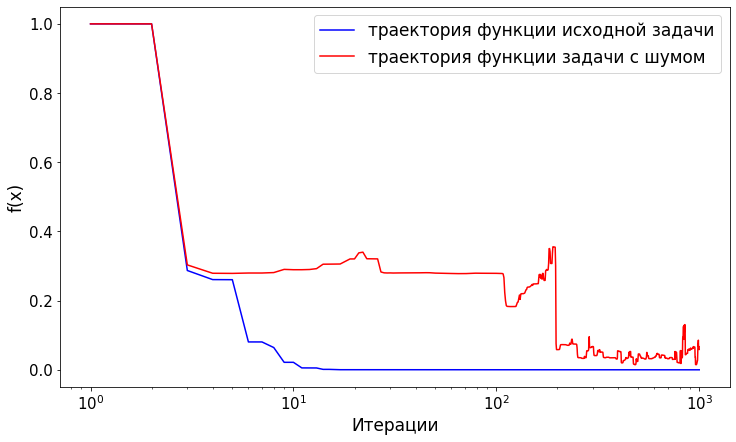

In [ ]:
f = plt.figure(figsize=(12,7))
# plt.plot(basic_x_stop, basic_y_stop, 'r|', label='basic stop point', ms = 15)
plt.semilogx(np.linspace(1, len(clear_task_res['trajectory']), len(clear_task_res['trajectory'])), func_trajectory, color='b', label='траектория функции исходной задачи')
plt.semilogx(np.linspace(1, len(noisy_task_res['trajectory']), len(noisy_task_res['trajectory'])), noisy_func_trajectory, color='r', label='траектория функции задачи с шумом')
# plt.ylim(func['f'](clear_task_res['trajectory'][-1]) - 1, func['f'](noisy_task_res['trajectory'][-1]) + 5)
# plt.xlim(-0.1, 10)

# plt.title(f'\n Шум в матрице и враждебный шум в векторе $b$.\n n = {N} \t $\delta_A$ = {d_A} \t $\delta_b$ = {d_b}\t R = {int(R)}', fontsize=17)
plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)

plt.show();
# f.savefig(f"Noisy_matrix_and_vector_antag_d_A{d_A}_d_b{d_b}_dim{N}.pdf", bbox_inches='tight')

## $R$ dependency

In [ ]:
N = 100

d_b = 0.01
d_A = 0.001
R_min = 0
R_max = 51.25
R = np.arange(R_min, R_max, (R_max - R_min) / 41)
len(R)

41

In [ ]:
A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=1000, eig_val_std1=0.008, eig_val_std2=1, R=R, verbose=True)

Cond: 353564.8129869974


In [ ]:
f_errors = []
x_errors = []
for i in range(len(R)):
    # if i % 10 == 0:
        # print(f'{int(i/len(R) * 100)}%')
    print(f'{int(i/len(R) * 100)}%')
    
    func = qf_params_cp(A, b[i])
    noisy_A = make_noisy_A(A, d_A)
    noisy_b = make_noisy_b(b[i], d_b, concept=3)

    solver1 = CG_solver_cp(starter_A=A, starter_b=b[i], accuracy=1e-2, factor=1, verbose=False)
    clear_task_res = solver1.solve(x0, early_stop=False)
    solver1 = CG_solver_cp(starter_A=A, starter_b=b[i], accuracy=1e-2, factor=100, A=noisy_A, b=noisy_b, verbose=False)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=3, early_stop=False)

    f_errors.append(np.abs(func['f'](noisy_task_res['trajectory'][-1]) - func['f'](clear_task_res['trajectory'][-1])))
    x_errors.append(np.linalg.norm(noisy_task_res['trajectory'][-1] - clear_task_res['trajectory'][-1]))
print('100%')

0%
2%
4%
7%
9%
12%
14%
17%
19%
21%
24%
26%
29%
31%
34%
36%
39%
41%
43%
46%
48%
51%
53%
56%
58%
60%
63%
65%
68%
70%
73%
75%
78%
80%
82%
85%
87%
90%
92%
95%
97%
100%


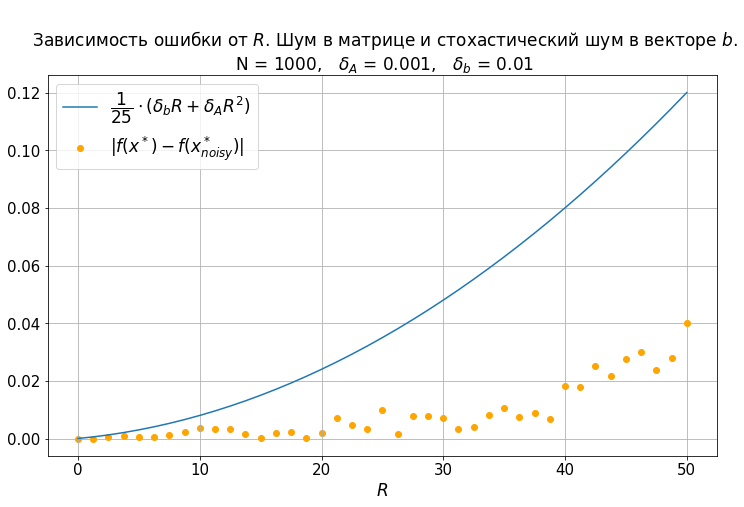

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(R, np.array(f_errors), label='$|f(x^*) - f(x^*_{noisy})|$', color='orange')
plt.plot(R, 0.04 * (d_b * R + d_A * R**2), label='$\dfrac{1}{25}\cdot (\delta_b R + \delta_A R^2)$')
# plt.plot(R, 0.02 * d_A * R**2, label='$\dfrac{1}{10}\cdot \delta_A R^2$')
plt.title(f'\n Зависимость ошибки от $R$. Шум в матрице и стохастический шум в векторе $b$.\n N = {N},   $\delta_A$ = {d_A},   $\delta_b$ = {d_b}', fontsize=17)# Коэффициент наклона: {round(reg.coef_[0], 2)}', fontsize=15)
plt.xlabel('$R$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(-0.006, 0.126)
plt.legend(loc='upper left', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_and_vector_f_error_dim{N}_d_A{d_A}_d_b{d_b}stoch_R{round(R[0])}-{round(R[-1])}.pdf", bbox_inches='tight')

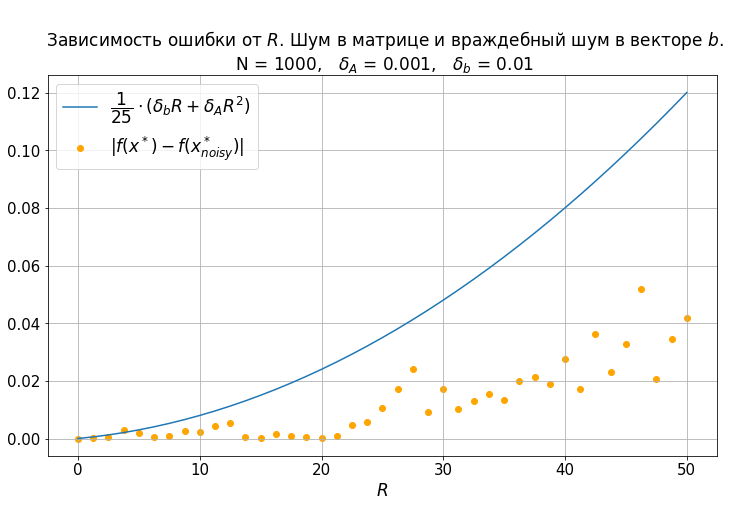

In [ ]:
f = plt.figure(figsize=(12,7))
plt.scatter(R, np.array(f_errors), label='$|f(x^*) - f(x^*_{noisy})|$', color='orange')
plt.plot(R, 0.04 * (d_b * R + d_A * R**2), label='$\dfrac{1}{25}\cdot (\delta_b R + \delta_A R^2)$')
# plt.plot(R, 0.02 * d_A * R**2, label='$\dfrac{1}{10}\cdot \delta_A R^2$')
plt.title(f'\n Зависимость ошибки от $R$. Шум в матрице и враждебный шум в векторе $b$.\n N = {N},   $\delta_A$ = {d_A},   $\delta_b$ = {d_b}', fontsize=17)# Коэффициент наклона: {round(reg.coef_[0], 2)}', fontsize=15)
plt.xlabel('$R$', fontsize=17)
plt.ylabel('', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.ylim(-0.20000000000000007, 4.200000000000001)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show();
# f.savefig(f"Noisy_matrix_and_vector_f_error_dim{N}_d_A{d_A}_d_b{d_b}antog_R{round(R[0])}-{round(R[-1])}.pdf", bbox_inches='tight')

# Research in "average" at the choice of a starting point

In [ ]:
def sample_random_start_point(x_star, radius):
    random_vector = cp.array(np.random.uniform(-1, 1, len(x_star)))
    return np.sqrt((random_vector * np.random.uniform(0, radius))**2 / (random_vector**2).sum()) * np.sign(random_vector) + x_star

In [ ]:
def prepare_results(arr, min_f):
    for i in range(len(arr)):
        arr[i] = np.concatenate((arr[i], np.array([arr[i][-1]] * (clear_longest_run - len(arr[i])))), axis=0)
    arr = np.array(arr)

    for i in range(len(arr)):
        arr[i] = (arr[i] - min_f) / (arr.T[0].max() - min_f)
        # arr[i] = (arr[i] - min_f) / (arr[i][0] - min_f)
    means = arr.mean(axis=0)
    stds = arr.std(axis=0)
    return arr, means, stds

In [ ]:
%%time
N = 2000
# R = 50
# A, b, x0 = make_task(N, min_eig_val_mean=0.01, max_eig_val_mean=100000, eig_val_std1=0.008, eig_val_std2=10, verbose=True)
A, b, x0 = make_task(N, min_eig_val_mean=1, max_eig_val_mean=N**2*100, eig_val_std1=0.9, eig_val_std2=100, verbose=True)
# A, b, x0 = make_task(N, verbose=True, seq=True)

Cond: 3956586896.1389227
CPU times: user 41.4 s, sys: 1min 8s, total: 1min 50s
Wall time: 28 s


In [ ]:
%%time
func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
scipy_res = minimize(func_np['f'], cp.asnumpy(x0), method='CG', jac=func_np['grad'], options={'disp': True})

         Current function value: -0.126081
         Iterations: 20800
         Function evaluations: 32058
         Gradient evaluations: 32044
CPU times: user 3min 40s, sys: 5min 32s, total: 9min 12s
Wall time: 2min 19s


In [ ]:
%%time
func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': True})

         Current function value: -226.847455
         Iterations: 19
         Function evaluations: 95
         Gradient evaluations: 83
CPU times: user 40.8 s, sys: 10.2 s, total: 51 s
Wall time: 13 s


Conjugate gradient method

In [ ]:
%%time
x_star = cp.array(scipy_res.x)
radius = 10000

d_b = 0.1
d_A = 0.0025
func = qf_params_cp(A, b)
noisy_A = make_noisy_A(A, d_A)
noisy_b = make_noisy_b(b, d_b, concept=3)

clear_task_trajectories = []
noisy_task_trajectories = []
clear_longest_run = 0
noisy_longest_run = 0

for j in range(50):    
    x0 = sample_random_start_point(x_star, radius)
    
    solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1)
    clear_task_res = solver1.solve(x0, early_stop=False)
    # solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, A=noisy_A, b=noisy_b)
    # noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=3, early_stop=False)

    clear_task_trajectories.append(np.array(clear_task_res['func']))
    # noisy_task_trajectories.append(np.array(noisy_task_res['func']))
    clear_longest_run = max(clear_longest_run, clear_task_res['num_iter']+1)
    # noisy_longest_run = max(noisy_longest_run, noisy_task_res['num_iter']+1)
    print(f'{int((j+1)/50 * 100)}%')

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
2%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
4%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
6%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
8%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
10%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 1700
i: 1800
i: 1900
12%
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 1000
i: 1100
i: 1200
i: 1300
i: 1400
i: 1500
i: 1600
i: 

##### Nesterov method

In [ ]:
%%time
x_star = cp.array(scipy_res.x)
radius = 10000

d_b = 0.1
d_A = 0.0025
func = qf_params_cp(A, b)
noisy_A = make_noisy_A(A, d_A)
noisy_b = make_noisy_b(b, d_b, concept=3)

clear_task_trajectories = []
noisy_task_trajectories = []
clear_longest_run = 0
noisy_longest_run = 0

for j in range(1):    
    x0 = sample_random_start_point(x_star, radius)
    
    solver1 = Nesterov_method_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, alpha=0.00001, beta=0.95)
    clear_task_res = solver1.solve(x0, early_stop=False)
    solver1 = Nesterov_method_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, alpha=0.00001, beta=0.95, A=noisy_A, b=noisy_b)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=3, early_stop=False)

    clear_task_trajectories.append(np.array(clear_task_res['func']))
    noisy_task_trajectories.append(np.array(noisy_task_res['func']))
    clear_longest_run = max(clear_longest_run, clear_task_res['num_iter']+1)
    noisy_longest_run = max(noisy_longest_run, noisy_task_res['num_iter']+1)
    print(f'{int((j+1) / 50 * 100)}%')

i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900
2%
CPU times: user 56.3 s, sys: 883 ms, total: 57.2 s
Wall time: 57.2 s


#### Next

In [ ]:
def prepare_results(arr, min_f):
    for i in range(len(arr)):
        arr[i] = np.concatenate((arr[i], np.array([arr[i][-1]] * (clear_longest_run - len(arr[i])))), axis=0)
    arr = np.array(arr)

    for i in range(len(arr)):
        # arr[i] = (arr[i] - min_f[i]) / (arr.T[0].max() - min_f[i])
        arr[i] = (arr[i] - min_f) / (arr[i][0] - min_f)
    means = arr.mean(axis=0)
    stds = arr.std(axis=0)
    return arr, means, stds

In [ ]:
%%time
clear, clear_means, clear_stds = prepare_results(clear_task_trajectories, scipy_res.fun)
# noisy, noisy_means, noisy_stds = prepare_results(noisy_task_trajectories, scipy_res.fun)

CPU times: user 2.64 ms, sys: 646 µs, total: 3.28 ms
Wall time: 2.99 ms


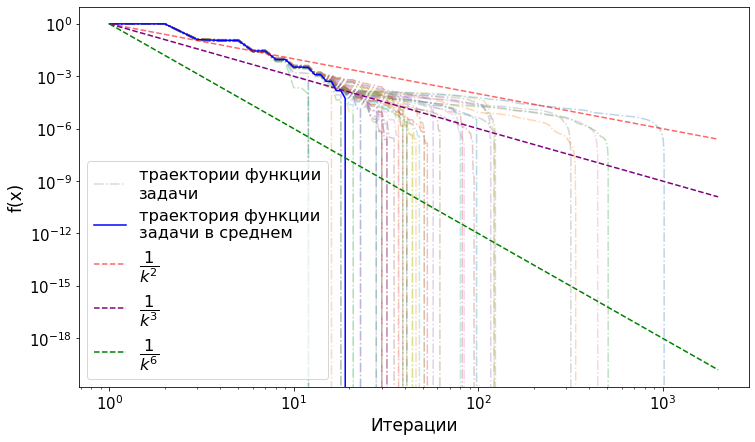

In [ ]:
f = plt.figure(figsize=(12,7))
length = len(clear_means)
plt.loglog(np.linspace(1, length, length), clear[0], '-.', color='gray', alpha=0.3, label='траектории функции\nзадачи')
for i in range(len(clear)-1):
    plt.loglog(np.linspace(1, length, length), clear[i+1], '-.', alpha=0.3)

# plt.loglog(np.linspace(1, length, length), clear_means + clear_stds, '-.',  color='b', alpha=0.4,
#              label='стандартное отклонение траекторий\nфункции исходной задачи')
# plt.loglog(np.linspace(1, length, length), clear_means - clear_stds, '-.', color='b', alpha=0.4)

plt.loglog(np.linspace(1, length, length), clear_means, color='b', label='траектория функции\nзадачи в среднем')

plt.loglog(np.linspace(1, length, length), np.linspace(1, length, length)**-2, '--', color='red', alpha=0.6, label='$\dfrac{1}{k^2}$')
plt.loglog(np.linspace(1, length, length), np.linspace(1, length, length)**-3, '--', color='purple', label='$\dfrac{1}{k^3}$')
plt.loglog(np.linspace(1, length, length), np.linspace(1, length, length)**-6, '--', color='green', label='$\dfrac{1}{k^6}$')

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=16.25)
# plt.ylim((-0.05002539376344055, 1.0500012092268305))

plt.show();
# f.savefig(f"CGM_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_radius{radius}_50.pdf", bbox_inches='tight')
# f.savefig(f"Nesterov_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_radius{radius}.pdf", bbox_inches='tight')
# f.savefig(f"three_hyps_clean_uniform_spectre.pdf", bbox_inches='tight')

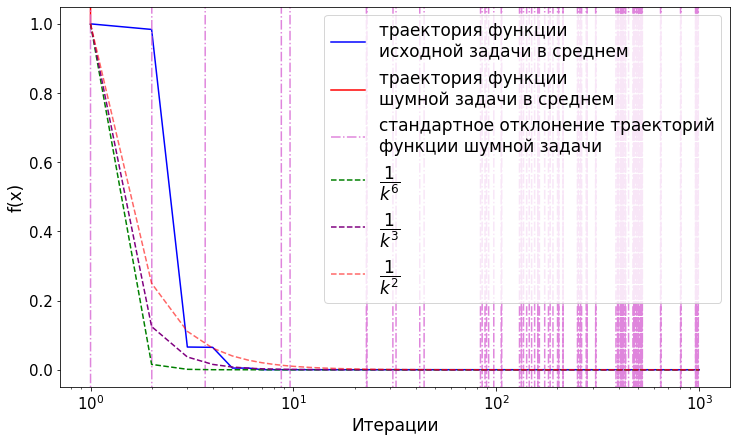

In [ ]:
f = plt.figure(figsize=(12,7))
# plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[0], '--', color='gray', alpha=0.2, label='траектории функции\nшумной задачи')
# for i in range(len(noisy)-1):
#     plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[i+1], '--', alpha=0.2)

plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), clear_means.tolist() +\
             [clear_means[-1]]*(len(noisy_means)-len(clear_means)), color='b', label='траектория функции\nисходной задачи в среднем')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means, color='r', label='траектория функции\nшумной задачи в среднем')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means + noisy_stds, '-.',  color='orchid', alpha=0.85,
             label='стандартное отклонение траекторий\nфункции шумной задачи')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means - noisy_stds, '-.', color='orchid', alpha=0.85)

plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), np.linspace(1, len(noisy_means), len(noisy_means))**-6, '--', color='green', label='$\dfrac{1}{k^6}$')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), np.linspace(1, len(noisy_means), len(noisy_means))**-3, '--', color='purple', label='$\dfrac{1}{k^3}$')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), np.linspace(1, len(noisy_means), len(noisy_means))**-2, '--', color='red', alpha=0.6, label='$\dfrac{1}{k^2}$')


plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
plt.ylim((-0.05002539376344055, 1.0500012092268305))

plt.show();
# f.savefig(f"Noisy_CGM_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_R{radius}_std.pdf", bbox_inches='tight')
# f.savefig(f"Noisy_Nesterov_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_R{radius}.pdf", bbox_inches='tight')
# f.savefig(f"three_hyps_noisy.pdf", bbox_inches='tight')

In [ ]:
pts = []
x_star = np.array([1, 2, 3, 4])
radius = 1000

for _ in range(100):
    pts.append(np.linalg.norm(sample_random_start_point(x_star, radius) - x_star))

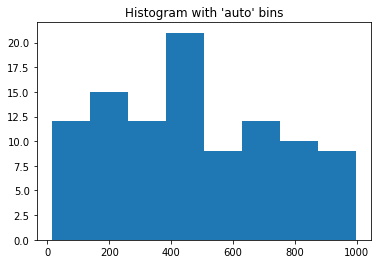

In [ ]:
_ = plt.hist(pts, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")

plt.show()

# Research in "average" at the choice of a spectre

In [ ]:
def prepare_results_spectre(arr, min_f):
    for i in range(len(arr)):
        arr[i] = np.concatenate((arr[i], np.array([arr[i][-1]] * (clear_longest_run - len(arr[i])))), axis=0)
    arr = np.array(arr)

    for i in range(len(arr)):
        # arr[i] = (arr[i] - min_f[i]) / (arr.T[0].max() - min_f[i])
        arr[i] = (arr[i] - min_f[i]) / (arr[i][0] - min_f[i])
    means = arr.mean(axis=0)
    stds = arr.std(axis=0)
    return arr, means, stds

Conjugate Gradient method

In [ ]:
%%time
N = 50
d_b = 0.1
d_A = 0.0025

clear_task_trajectories = []
noisy_task_trajectories = []
scipy_results = []
clear_longest_run = 0
noisy_longest_run = 0

for j in range(200): 
    A, b, x0 = make_task(N, verbose=True, uniform=True)

    func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
    scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': False})
    scipy_results.append(scipy_res.fun)

    func = qf_params_cp(A, b)
    noisy_A = make_noisy_A(A, d_A)
    noisy_b = make_noisy_b(b, d_b, concept=3)

    solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1)
    clear_task_res = solver1.solve(x0, early_stop=False)
    solver1 = CG_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, A=noisy_A, b=noisy_b)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=3, early_stop=False)

    clear_task_trajectories.append(np.array(clear_task_res['func']))
    noisy_task_trajectories.append(np.array(noisy_task_res['func']))
    clear_longest_run = max(clear_longest_run, clear_task_res['num_iter']+1)
    noisy_longest_run = max(noisy_longest_run, noisy_task_res['num_iter']+1)
    print(f'{int((j+1) / 200 * 100)}%')

Cond: 735.1257750879763
0%
Cond: 35.9226487129066
1%
Cond: 78.41478833458466
1%
Cond: 63.10157776418721
2%
Cond: 32.67728246793005
2%
Cond: 26.382062026286423
3%
Cond: 769.4166680809996
3%
Cond: 159.79292702133662
4%
Cond: 27.56731364545239
4%
Cond: 35.8281915147521
5%
Cond: 18.945400458546477
5%
Cond: 68.58198007179584
6%
Cond: 23.255642626526836
6%
Cond: 54.35528026661966
7%
Cond: 255.39901789506033
7%
Cond: 87.80203139862694
8%
Cond: 173.05514366476282
8%
Cond: 1438.985289884284
9%
Cond: 468.22251510868955
9%
Cond: 25.83022469684099
10%
Cond: 80.64079301764407
10%
Cond: 626.3534486993196
11%
Cond: 99.09925963998093
11%
Cond: 454.77311417365104
12%
Cond: 51.49470092484468
12%
Cond: 16.167336701070585
13%
Cond: 244.09383139010808
13%
Cond: 365.8778803405775
14%
Cond: 231.6505651232428
14%
Cond: 2290.1381723411764
15%
Cond: 55.81896482066185
15%
Cond: 231.2145452286078
16%
Cond: 15.452197309279619
16%
Cond: 1080.8169016957606
17%
Cond: 450.5767218070265
17%
Cond: 49.12626819277897
18%


Nesterov method

In [ ]:
%%time
N = 1000
d_b = 0.1
d_A = 0.0025

clear_task_trajectories = []
noisy_task_trajectories = []
scipy_results = []
clear_longest_run = 0
noisy_longest_run = 0

for j in range(1): 
    A, b, x0 = make_task(N, verbose=True, uniform=True)

    func_np = qf_params(cp.asnumpy(A), cp.asnumpy(b))
    scipy_res = minimize(func_np['f'], cp.asnumpy(x0), jac=func_np['grad'], options={'disp': False})
    scipy_results.append(scipy_res.fun)

    func = qf_params_cp(A, b)
    noisy_A = make_noisy_A(A, d_A)
    noisy_b = make_noisy_b(b, d_b, concept=3)

    solver1 = Nesterov_method_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, alpha=0.001, beta=0.95)
    clear_task_res = solver1.solve(x0, early_stop=False)
    solver1 = Nesterov_method_solver_cp(starter_A=A, starter_b=b, accuracy=1e-2, factor=1, alpha=0.001, beta=0.95, A=noisy_A, b=noisy_b)
    noisy_task_res = solver1.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=d_A, delta_b=d_b, concept=3, early_stop=False)

    clear_task_trajectories.append(np.array(clear_task_res['func']))
    noisy_task_trajectories.append(np.array(noisy_task_res['func']))
    clear_longest_run = max(clear_longest_run, clear_task_res['num_iter']+1)
    noisy_longest_run = max(noisy_longest_run, noisy_task_res['num_iter']+1)
    print(f'{int((j+1) / 50 * 100)}%')

In [ ]:
%%time
clear, clear_means, clear_stds = prepare_results_spectre(clear_task_trajectories, scipy_results)
noisy, noisy_means, noisy_stds = prepare_results_spectre(noisy_task_trajectories, scipy_results)

CPU times: user 6.3 ms, sys: 2.67 ms, total: 8.96 ms
Wall time: 8.2 ms


In [ ]:
clear = clear[:50]

In [ ]:
# clear = [clear[i] +\
#              [clear[i][-1]]*(len(noisy_means)-len(clear[i])) for i in range(len(clear))]
# clear_means = clear_means.tolist() +\
#              [clear_means[-1]]*(len(noisy_means)-len(clear_means))
clear_stds = clear_stds +\
             [clear_stds[-1]]*(len(noisy_means)-len(clear_stds))

In [ ]:
len(clear_stds)

209

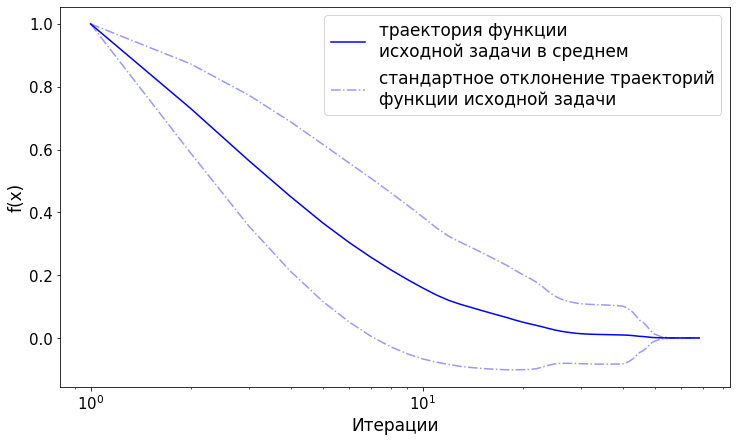

In [ ]:
f = plt.figure(figsize=(12,7))
rng = len(clear_means)
# plt.semilogx(np.linspace(1, rng, rng), clear[0], '--', color='gray', alpha=0.35, label='траектории функции\nисходной задачи')
# for i in range(len(noisy)-1):
#     plt.semilogx(np.linspace(1, rng, rng), clear[i+1], '--', alpha=0.35)
# plt.semilogx(np.linspace(1, rng, rng), np.linspace(1, rng, rng)**-2)
plt.semilogx(np.linspace(1, rng, rng), clear_means, color='b', label='траектория функции\nисходной задачи в среднем')
plt.semilogx(np.linspace(1, rng, rng), np.array(clear_means) + np.array(clear_stds), '-.',  color='b', alpha=0.4,
             label='стандартное отклонение траекторий\nфункции исходной задачи')
plt.semilogx(np.linspace(1, rng, rng), np.array(clear_means) - np.array(clear_stds), '-.', color='b', alpha=0.4)

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
# plt.ylim((-0.05002539376344055, 1.0500012092268305))

plt.show();
# f.savefig(f"CGM_MEAN_SPECTRE_d_A{d_A}_d_b{d_b}_dim{N}_std.pdf", bbox_inches='tight')

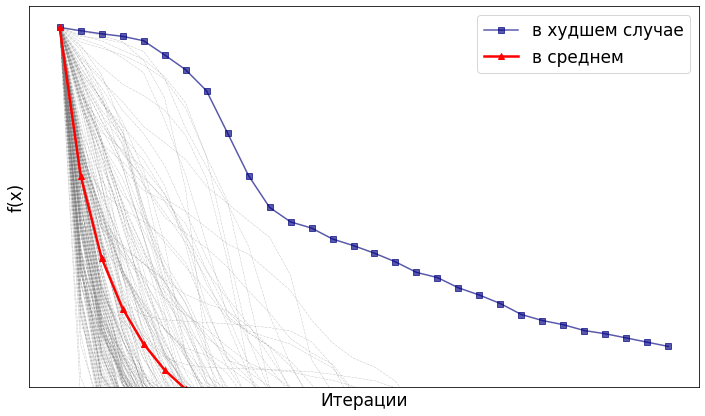

In [ ]:
f = plt.figure(figsize=(12,7))
rng = len(clear_means[:30])
plt.plot(np.linspace(1, rng, rng), line, '-s', color='navy', alpha=0.65, linewidth=1.5, label='в худшем случае')
plt.plot(np.linspace(1, rng, rng), clear[0][:30], '-.', color='grey', alpha=0.65, linewidth=0.35)
for i in range(len(clear)-1):
    plt.plot(np.linspace(1, rng, rng), clear[i+1][:30], '-.', color='grey', alpha=0.65, linewidth=0.35)
plt.plot(np.linspace(1, rng, rng), clear_means[:30], "-^", color='red', alpha=1, linewidth=2.5, label='в среднем')

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.tick_params(
    axis='both',    # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, left=False, labelleft=False) # labels along the bottom edge are off
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
# plt.ylim((-0.05002539376344055, 1.0500012092268305))
plt.ylim((0.14999980607913111, 1.049999990765673))

plt.show();
f.savefig(f"mean_title.pdf", bbox_inches='tight')

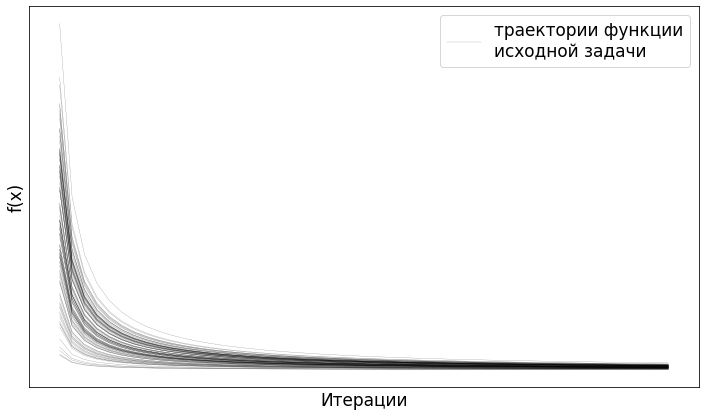

In [ ]:
f = plt.figure(figsize=(12,7))
# plt.plot(np.linspace(1, 50, 50), funct(np.linspace(1, 50, 50), 0.001), '-s', color='navy', alpha=1, linewidth=1, label='траектории функции\nисходной задачи')
plt.plot(np.linspace(1, 50, 50), funct(np.linspace(1, 50, 50), a[0]), color='black', alpha=0.5, linewidth=0.25, label='траектории функции\nисходной задачи')
for i in range(len(a)-1):
    plt.plot(np.linspace(1, 50, 50), funct(np.linspace(1, 50, 50), a[i]), color='black', alpha=0.5, linewidth=0.25)

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.tick_params(
    axis='both',    # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, left=False, labelleft=False) # labels along the bottom edge are off
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
# plt.ylim((-0.05002539376344055, 1.0500012092268305))
# plt.ylim((0.14999980607913111, 1.049999990765673))

plt.show();
# f.savefig(f"CGM_MEAN_SPECTRE_d_A{d_A}_d_b{d_b}_dim{N}_std.pdf", bbox_inches='tight')

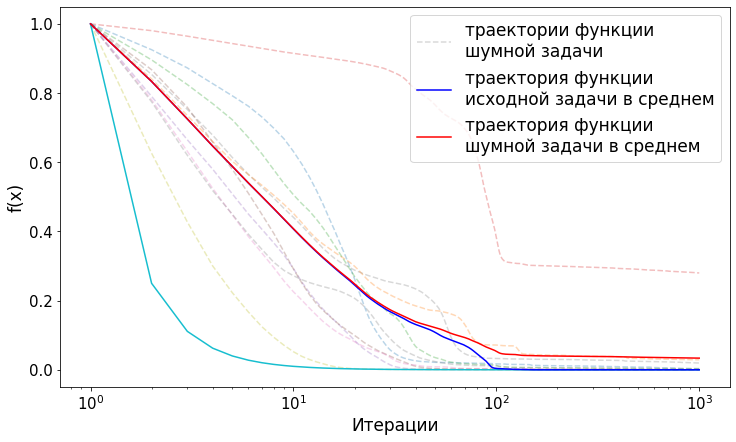

In [ ]:
f = plt.figure(figsize=(12,7))
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[0], '--', color='gray', alpha=0.3, label='траектории функции\nшумной задачи')
for i in range(len(noisy)-1):
    plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[i+1], '--', alpha=0.3)
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), np.linspace(1, len(noisy_means), len(noisy_means))**-2)
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), clear_means.tolist() +\
             [clear_means[-1]]*(len(noisy_means)-len(clear_means)), color='b', label='траектория функции\nисходной задачи в среднем')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means, color='r', label='траектория функции\nшумной задачи в среднем')
# plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means + noisy_stds, '-.',  color='orchid', alpha=0.7,
#              label='стандартное отклонение траекторий\nфункции шумной задачи')
# plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means - noisy_stds, '-.', color='orchid', alpha=0.7)

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
# plt.xlim((0.7079812002696424, 1411.054417291758))
# plt.ylim((-0.05002539376344055, 1.0500012092268305))

plt.show();
# f.savefig(f"Noisy_CGM_MEAN_SPECTRE_d_A{d_A}_d_b{d_b}_dim{N}_50.pdf", bbox_inches='tight')

In [ ]:
f = plt.figure(figsize=(12,7))
# plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[0], '--', color='gray', alpha=0.3, label='траектории функции\nшумной задачи')
# for i in range(len(noisy)-1):
#     plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy[i+1], '--', alpha=0.3)

plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), clear_means.tolist() +\
             [clear_means[-1]]*(len(noisy_means)-len(clear_means)), color='b', label='траектория функции\nисходной задачи в среднем')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means, color='r', label='траектория функции\nшумной задачи в среднем')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means + noisy_stds, '-.',  color='orchid', alpha=0.7,
             label='стандартное отклонение траекторий\nфункции шумной задачи')
plt.semilogx(np.linspace(1, len(noisy_means), len(noisy_means)), noisy_means - noisy_stds, '-.', color='orchid', alpha=0.7)

plt.xlabel('Итерации', fontsize=17)
plt.ylabel('f(x)', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='best', fontsize=17)
plt.ylim((-0.05002539376344055, 1.0500012092268305))

plt.show();
# f.savefig(f"Noisy_CGM_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_R{radius}_std.pdf", bbox_inches='tight')
# f.savefig(f"Noisy_Nesterov_MEAN_d_A{d_A}_d_b{d_b}_dim{N}_R{radius}.pdf", bbox_inches='tight')